## CNN+LSTM

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import gym
%matplotlib inline

In [18]:
import cv2

def preprocess(image):
    def_h = 84
    def_w = 84
    img = 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]
    img = cv2.resize(img, (def_h, def_w))
    img = np.expand_dims(img, axis=2)
    return img

def preprocess_tensor(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], tensor.shape[1], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        for j in xrange(tensor.shape[1]):
            img = 0.299*tensor[i,j,:,:,0] + 0.587*tensor[i,j,:,:,1] + 0.114*tensor[i,j,:,:,2]
            tnsr[i,j,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

def preprocess_tensor4(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        img = 0.299*tensor[i,:,:,0] + 0.587*tensor[i,:,:,1] + 0.114*tensor[i,:,:,2]
        tnsr[i,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

### Game Parameters

In [24]:
experiment_setup_name = "tutorial.gym.atari.MsPacman-v0.cnn"
GAME_TITLE = 'MsPacman-v0'
N_PARALLEL_GAMES = 20
replay_seq_len = 50

atari = gym.make(GAME_TITLE)
atari.reset()
n_actions = atari.action_space.n
observation_shape = (None,) + (84, 84, 1)
action_names = ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [25]:
observation_shape

(None, 84, 84, 1)

In [26]:
del atari

### Observations

In [27]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer

observation_layer = InputLayer(observation_shape, name="images input")
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))

### Memory layer

In [29]:
from agentnet.memory import WindowAugmentation
window_size = 4

prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")

window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")

memory_dict = {window:prev_window}

### Policy

In [30]:
from lasagne.layers import DenseLayer, ExpressionLayer
from lasagne.nonlinearities import elu, leaky_rectify
from agentnet.memory import LSTMCell

window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])

nn = lasagne.layers.Conv2DLayer(window_max, num_filters=16, filter_size=(8, 8), stride=(4, 4), nonlinearity=leaky_rectify)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=32, filter_size=(4, 4), stride=(2, 2), nonlinearity=leaky_rectify)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=256)
nn = lasagne.layers.BatchNormLayer(nn)

prev_cell = InputLayer((None,256))
prev_out = InputLayer((None,256))

new_cell,new_out = LSTMCell(prev_cell,prev_out,nn,name='lstm')
memory_dict[new_cell] = prev_cell
memory_dict[new_out] = prev_out

### Resolver

In [31]:
from agentnet.resolver import EpsilonGreedyResolver

q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")
resolver = EpsilonGreedyResolver(q_eval,name="resolver")

### Putting it together

In [33]:
from agentnet.agent import Agent

agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)

weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 lstm.b_to_ingate,
 lstm.W_ctrl0_to_ingate,
 lstm.W_ctrl1_to_ingate,
 lstm.b_to_forgetgate,
 lstm.W_ctrl0_to_forgetgate,
 lstm.W_ctrl1_to_forgetgate,
 lstm.b_to_cell,
 lstm.W_ctrl0_to_cell,
 lstm.W_ctrl1_to_cell,
 lstm.b_to_outgate,
 lstm.W_ctrl0_to_outgate,
 lstm.W_ctrl1_to_outgate,
 lstm.W_cell_to_ingate_peephole.scales,
 lstm.W_cell_to_forgetgate_peephole.scales,
 lstm.W_cell_to_outgate_peephole.scales,
 QEvaluator.W,
 QEvaluator.b]

### Step Function

In [34]:
applier_fun = agent.get_react_function()

def step(observation, prev_memories_w = 'zeros', prev_memories_c = 'zeros', prev_memories_o = 'zeros', bs=N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    
    zeros_arr = agent.get_zeros_like_memory(batch_size=bs)
    if prev_memories_w == 'zeros':
        prev_memories_w = zeros_arr[0]
    if prev_memories_c == 'zeros':
        prev_memories_c = zeros_arr[1]
    if prev_memories_o == 'zeros':
        prev_memories_o = zeros_arr[2]
    
    obs = preprocess_tensor4(np.array(observation))
    res = applier_fun(obs, prev_memories_w, prev_memories_c, prev_memories_o)
    action = res[0]
    memories = res[1:]
    return action, memories[0], memories[1], memories[2]

### Environment, pool and all other stuff

In [35]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, n_games=N_PARALLEL_GAMES, make_env=GAME_TITLE, agent_step=step)

[2017-05-24 14:12:51,600] Making new env: MsPacman-v0
[2017-05-24 14:12:51,852] Making new env: MsPacman-v0
[2017-05-24 14:12:52,023] Making new env: MsPacman-v0
[2017-05-24 14:12:52,194] Making new env: MsPacman-v0
[2017-05-24 14:12:52,365] Making new env: MsPacman-v0
[2017-05-24 14:12:52,535] Making new env: MsPacman-v0
[2017-05-24 14:12:52,706] Making new env: MsPacman-v0
[2017-05-24 14:12:52,876] Making new env: MsPacman-v0
[2017-05-24 14:12:53,047] Making new env: MsPacman-v0
[2017-05-24 14:12:53,217] Making new env: MsPacman-v0
[2017-05-24 14:12:53,388] Making new env: MsPacman-v0
[2017-05-24 14:12:53,559] Making new env: MsPacman-v0
[2017-05-24 14:12:53,729] Making new env: MsPacman-v0
[2017-05-24 14:12:53,901] Making new env: MsPacman-v0
[2017-05-24 14:12:54,071] Making new env: MsPacman-v0
[2017-05-24 14:12:54,242] Making new env: MsPacman-v0


In [36]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[['LEFT' 'UPLEFT' 'UPLEFT' 'UPLEFT' 'RIGHT']
 ['LEFT' 'DOWN' 'DOWN' 'NOOP' 'NOOP']
 ['RIGHT' 'UPLEFT' 'DOWN' 'LEFT' 'NOOP']]
CPU times: user 2.64 s, sys: 8.54 s, total: 11.2 s
Wall time: 1.43 s


In [39]:
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.agent_states)

def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(n_steps=n_steps)
    observation_tensor = preprocess_tensor(observation_tensor)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
update_pool(env,pool,replay_seq_len)

/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### Loss

In [40]:
import sys
sys.setrecursionlimit(10000)

from agentnet.learning import qlearning
from lasagne.regularization import regularize_network_params, l2

#get agent's Qvalues obtained via experience replay
_,_,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)

scaled_reward_seq = env.rewards
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        env.actions[0],
                                                        scaled_reward_seq,
                                                        env.is_alive,
                                                        n_steps=10,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()
reg_l2 = regularize_network_params(resolver,l2)*10**-4
loss = mse_loss + reg_l2

updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

mean_session_reward = env.rewards.sum(axis=1).mean()

/home/weasel/anaconda2/lib/python2.7/site-packages/agentnet-0.10.5-py2.7.egg/agentnet/utils/logging.py:14: UserWarning: [Verbose>=1] optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [47]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

### Training

In [48]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.envs[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    

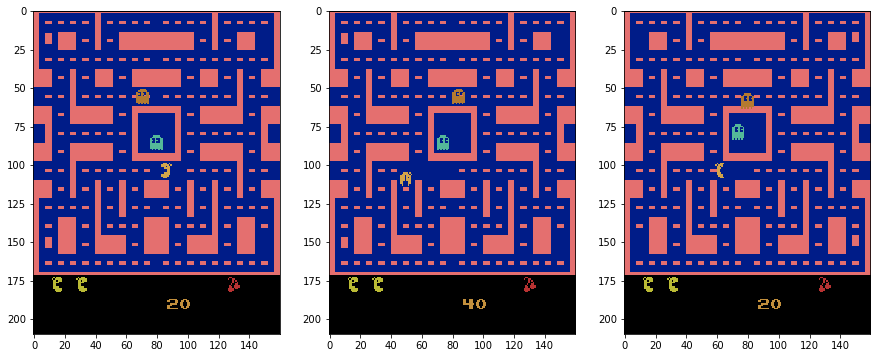

In [49]:
#visualize untrained network performance (which is mostly random)
display_sessions()

In [50]:
import os
from agentnet.display import Metrics

score_log = Metrics()
epoch_counter = 1
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [55]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 675kB/s ta 0:00:01


In [59]:
from tqdm import *

/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


epoch 5480,loss 883.90005, epsilon 0.05188, rewards: ( e-greedy 70.68656, greedy 80.11561) 
rec 883.789 reg 0.111
epoch 5490,loss 251.19706, epsilon 0.05186, rewards: ( e-greedy 70.36791, greedy 79.72905) 
rec 251.086 reg 0.111
epoch 5500,loss 450.40944, epsilon 0.05184, rewards: ( e-greedy 73.01861, greedy 78.88114) 
rec 450.298 reg 0.112
Learning curves:


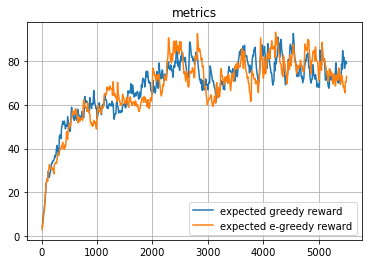

Random session examples


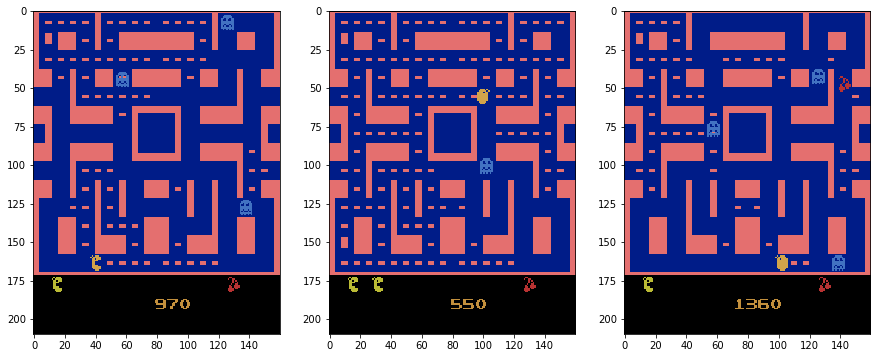

epoch 5510,loss 454.08242, epsilon 0.05182, rewards: ( e-greedy 75.09175, greedy 81.99303) 
rec 453.971 reg 0.112
epoch 5520,loss 1191.14171, epsilon 0.05180, rewards: ( e-greedy 79.52008, greedy 85.60623) 
rec 1191.030 reg 0.112
epoch 5530,loss 315.25173, epsilon 0.05178, rewards: ( e-greedy 78.06807, greedy 87.04560) 
rec 315.140 reg 0.112
epoch 5540,loss 1423.48511, epsilon 0.05177, rewards: ( e-greedy 80.13626, greedy 85.71604) 
rec 1423.374 reg 0.112
epoch 5550,loss 233.09948, epsilon 0.05175, rewards: ( e-greedy 77.06014, greedy 84.95694) 
rec 232.988 reg 0.112
epoch 5560,loss 1813.19269, epsilon 0.05173, rewards: ( e-greedy 75.97912, greedy 84.64874) 
rec 1813.081 reg 0.112
epoch 5570,loss 1617.98249, epsilon 0.05171, rewards: ( e-greedy 76.94371, greedy 88.87137) 
rec 1617.871 reg 0.112
epoch 5580,loss 597.14132, epsilon 0.05170, rewards: ( e-greedy 75.62434, greedy 88.98423) 
rec 597.030 reg 0.112
epoch 5590,loss 672.85230, epsilon 0.05168, rewards: ( e-greedy 74.62441, greedy

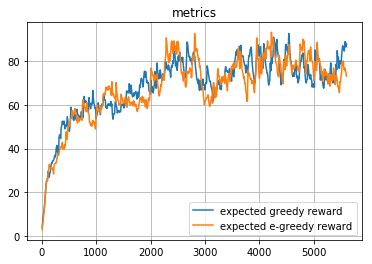

Random session examples


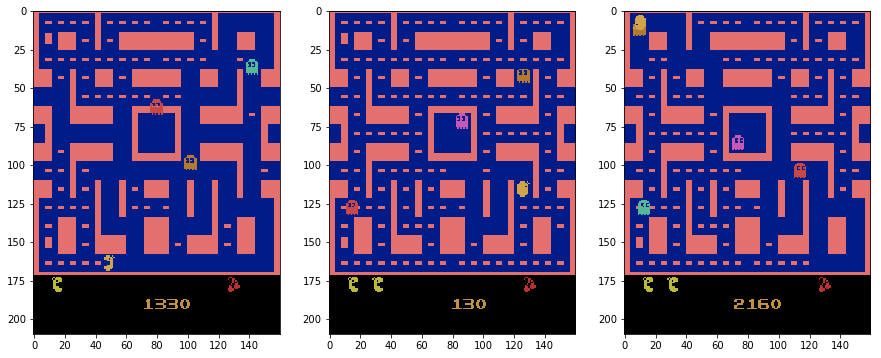

epoch 5610,loss 247.52249, epsilon 0.05165, rewards: ( e-greedy 70.03952, greedy 84.58951) 
rec 247.411 reg 0.112
epoch 5620,loss 258.54532, epsilon 0.05163, rewards: ( e-greedy 69.66057, greedy 81.75556) 
rec 258.434 reg 0.112
epoch 5630,loss 400.86846, epsilon 0.05161, rewards: ( e-greedy 69.81951, greedy 77.70500) 
rec 400.757 reg 0.112
epoch 5640,loss 892.10133, epsilon 0.05160, rewards: ( e-greedy 74.77506, greedy 82.74700) 
rec 891.990 reg 0.112
epoch 5650,loss 2097.36817, epsilon 0.05158, rewards: ( e-greedy 78.79755, greedy 83.03480) 
rec 2097.256 reg 0.112
epoch 5660,loss 337.70999, epsilon 0.05157, rewards: ( e-greedy 76.66780, greedy 82.48132) 
rec 337.598 reg 0.112
epoch 5670,loss 259.95435, epsilon 0.05155, rewards: ( e-greedy 74.87602, greedy 78.60819) 
rec 259.843 reg 0.112
epoch 5680,loss 382.31334, epsilon 0.05154, rewards: ( e-greedy 75.95092, greedy 78.68487) 
rec 382.201 reg 0.112
epoch 5690,loss 525.76647, epsilon 0.05152, rewards: ( e-greedy 77.41832, greedy 78.50

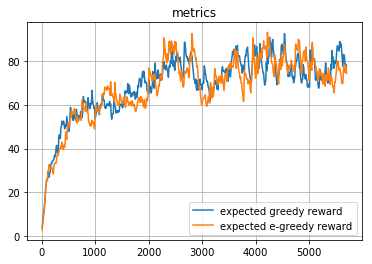

Random session examples


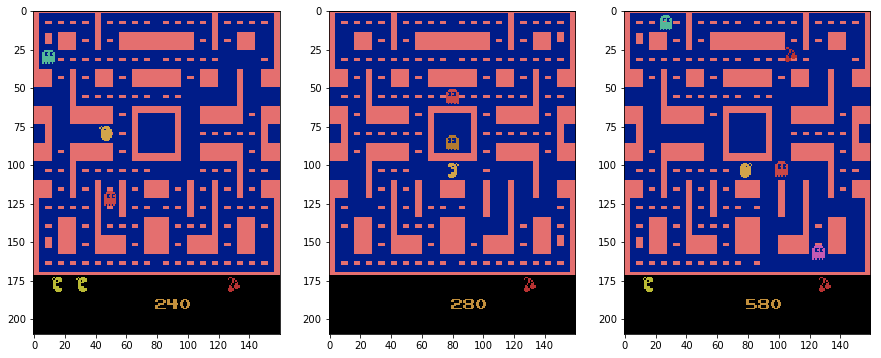

epoch 5710,loss 2351.72402, epsilon 0.05149, rewards: ( e-greedy 76.18384, greedy 78.02564) 
rec 2351.612 reg 0.112
epoch 5720,loss 395.70931, epsilon 0.05148, rewards: ( e-greedy 75.50296, greedy 78.22308) 
rec 395.597 reg 0.112
epoch 5730,loss 387.98794, epsilon 0.05146, rewards: ( e-greedy 74.07766, greedy 80.90077) 
rec 387.876 reg 0.112
epoch 5740,loss 252.34273, epsilon 0.05145, rewards: ( e-greedy 72.91990, greedy 77.68569) 
rec 252.231 reg 0.112
epoch 5750,loss 272.54379, epsilon 0.05143, rewards: ( e-greedy 70.56541, greedy 77.10463) 
rec 272.432 reg 0.112
epoch 5760,loss 577.19887, epsilon 0.05142, rewards: ( e-greedy 70.50887, greedy 78.95666) 
rec 577.087 reg 0.112
epoch 5770,loss 299.94626, epsilon 0.05140, rewards: ( e-greedy 70.02048, greedy 78.49850) 
rec 299.834 reg 0.112
epoch 5780,loss 319.21568, epsilon 0.05139, rewards: ( e-greedy 70.58093, greedy 83.83615) 
rec 319.104 reg 0.112
epoch 5790,loss 763.30429, epsilon 0.05138, rewards: ( e-greedy 70.52284, greedy 79.95

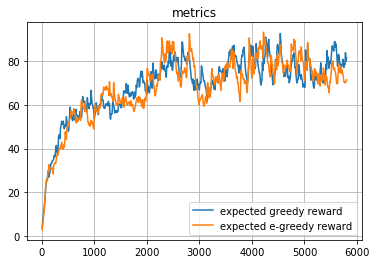

Random session examples


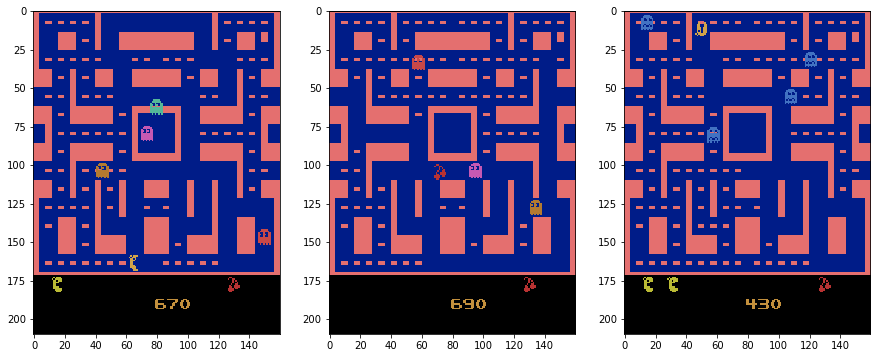

epoch 5810,loss 246.50169, epsilon 0.05135, rewards: ( e-greedy 70.13600, greedy 81.73655) 
rec 246.389 reg 0.112
epoch 5820,loss 501.58231, epsilon 0.05134, rewards: ( e-greedy 69.80990, greedy 81.75040) 
rec 501.470 reg 0.112
epoch 5830,loss 235.04132, epsilon 0.05132, rewards: ( e-greedy 68.70391, greedy 79.76286) 
rec 234.929 reg 0.112
epoch 5840,loss 253.17580, epsilon 0.05131, rewards: ( e-greedy 68.20852, greedy 83.78657) 
rec 253.063 reg 0.112
epoch 5850,loss 359.98567, epsilon 0.05130, rewards: ( e-greedy 68.13767, greedy 83.59541) 
rec 359.873 reg 0.112
epoch 5860,loss 1959.15458, epsilon 0.05128, rewards: ( e-greedy 69.82390, greedy 80.17337) 
rec 1959.042 reg 0.112
epoch 5870,loss 205.03731, epsilon 0.05127, rewards: ( e-greedy 68.02901, greedy 76.71854) 
rec 204.925 reg 0.113
epoch 5880,loss 294.36898, epsilon 0.05126, rewards: ( e-greedy 68.66361, greedy 77.67168) 
rec 294.256 reg 0.113
epoch 5890,loss 236.38452, epsilon 0.05125, rewards: ( e-greedy 67.35975, greedy 76.59

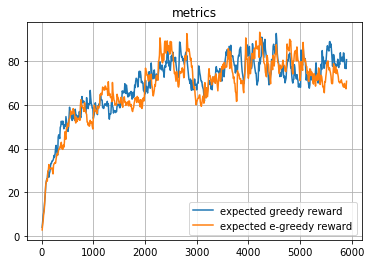

Random session examples


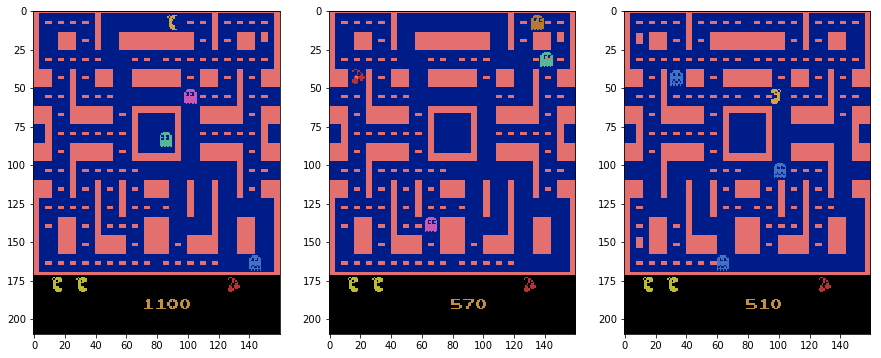

epoch 5910,loss 2161.76359, epsilon 0.05122, rewards: ( e-greedy 76.04265, greedy 79.61453) 
rec 2161.651 reg 0.113
epoch 5920,loss 262.05859, epsilon 0.05121, rewards: ( e-greedy 75.00088, greedy 77.52808) 
rec 261.946 reg 0.113
epoch 5930,loss 194.85711, epsilon 0.05120, rewards: ( e-greedy 72.31329, greedy 78.65027) 
rec 194.745 reg 0.113
epoch 5940,loss 300.96970, epsilon 0.05118, rewards: ( e-greedy 72.64446, greedy 77.16024) 
rec 300.857 reg 0.113
epoch 5950,loss 532.87305, epsilon 0.05117, rewards: ( e-greedy 71.06752, greedy 77.94422) 
rec 532.761 reg 0.113
epoch 5960,loss 269.23870, epsilon 0.05116, rewards: ( e-greedy 69.64827, greedy 78.27480) 
rec 269.126 reg 0.113
epoch 5970,loss 3242.13943, epsilon 0.05115, rewards: ( e-greedy 79.49594, greedy 81.82232) 
rec 3242.027 reg 0.113
epoch 5980,loss 479.98994, epsilon 0.05114, rewards: ( e-greedy 77.29635, greedy 80.39009) 
rec 479.877 reg 0.113
epoch 5990,loss 748.22672, epsilon 0.05113, rewards: ( e-greedy 79.94171, greedy 80.

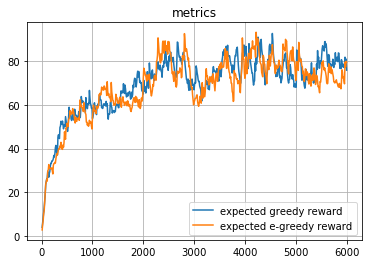

Random session examples


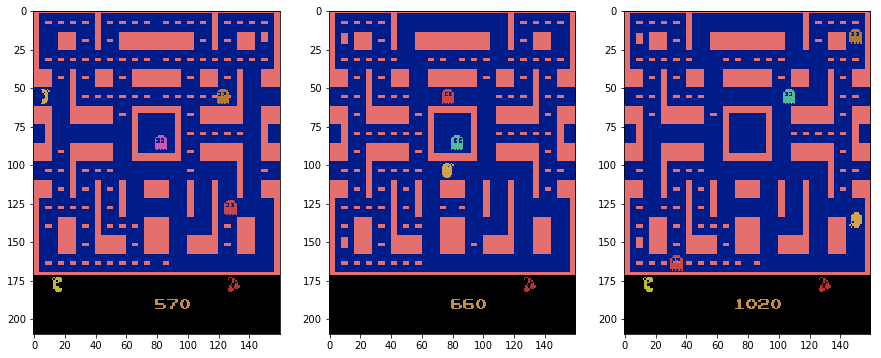

[2017-05-25 00:42:08,361] Making new env: MsPacman-v0
[2017-05-25 00:42:08,536] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 00:42:08,545] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.8.25470.video000000.mp4
[2017-05-25 00:42:11,774] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.8.25470.video000001.mp4


Episode finished after 635 timesteps with reward=240.0
Episode finished after 772 timesteps with reward=170.0
Episode finished after 557 timesteps with reward=260.0
Episode finished after 551 timesteps with reward=280.0
Episode finished after 627 timesteps with reward=240.0
Episode finished after 468 timesteps with reward=230.0
Episode finished after 1093 timesteps with reward=550.0


[2017-05-25 00:42:33,306] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.8.25470.video000008.mp4


Episode finished after 583 timesteps with reward=220.0
Episode finished after 731 timesteps with reward=220.0
Episode finished after 613 timesteps with reward=140.0
Episode finished after 720 timesteps with reward=240.0
Episode finished after 626 timesteps with reward=240.0
Episode finished after 665 timesteps with reward=290.0
Episode finished after 761 timesteps with reward=260.0
Episode finished after 839 timesteps with reward=240.0
Episode finished after 696 timesteps with reward=220.0
Episode finished after 754 timesteps with reward=230.0
Episode finished after 749 timesteps with reward=290.0
Episode finished after 640 timesteps with reward=290.0


[2017-05-25 00:43:10,109] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')


Episode finished after 504 timesteps with reward=140.0
Mean 249.5, Var 6524.75
epoch 6010,loss 975.45500, epsilon 0.05110, rewards: ( e-greedy 85.37779, greedy 75.16562) 
rec 975.342 reg 0.113
epoch 6020,loss 275.55639, epsilon 0.05109, rewards: ( e-greedy 81.77751, greedy 74.14906) 
rec 275.444 reg 0.113
epoch 6030,loss 388.37176, epsilon 0.05108, rewards: ( e-greedy 79.59976, greedy 74.04665) 
rec 388.259 reg 0.113
epoch 6040,loss 1264.81755, epsilon 0.05107, rewards: ( e-greedy 81.45228, greedy 78.32949) 
rec 1264.705 reg 0.113
epoch 6050,loss 197.61110, epsilon 0.05106, rewards: ( e-greedy 77.99455, greedy 75.55904) 
rec 197.498 reg 0.113
epoch 6060,loss 573.95128, epsilon 0.05105, rewards: ( e-greedy 76.00760, greedy 75.12814) 
rec 573.838 reg 0.113
epoch 6070,loss 1002.80347, epsilon 0.05104, rewards: ( e-greedy 78.53184, greedy 77.74032) 
rec 1002.690 reg 0.113
epoch 6080,loss 274.71110, epsilon 0.05103, rewards: ( e-greedy 79.05365, greedy 85.46629) 
rec 274.598 reg 0.113
epoch

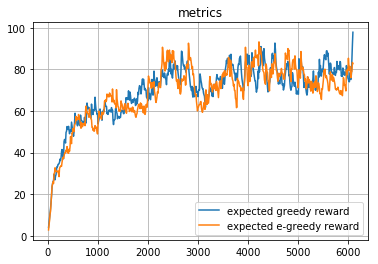

Random session examples


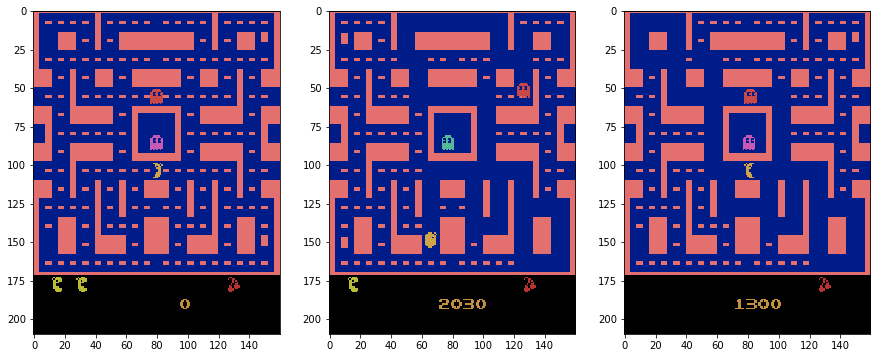

epoch 6110,loss 557.74114, epsilon 0.05100, rewards: ( e-greedy 83.53949, greedy 96.32868) 
rec 557.628 reg 0.113
epoch 6120,loss 1970.71766, epsilon 0.05099, rewards: ( e-greedy 84.43554, greedy 93.25831) 
rec 1970.604 reg 0.113
epoch 6130,loss 2795.56948, epsilon 0.05098, rewards: ( e-greedy 89.80449, greedy 90.24498) 
rec 2795.456 reg 0.113
epoch 6140,loss 265.38675, epsilon 0.05097, rewards: ( e-greedy 87.38654, greedy 88.59548) 
rec 265.273 reg 0.113
epoch 6150,loss 665.75684, epsilon 0.05096, rewards: ( e-greedy 88.52288, greedy 85.48593) 
rec 665.643 reg 0.114
epoch 6160,loss 299.77230, epsilon 0.05095, rewards: ( e-greedy 84.48310, greedy 81.68734) 
rec 299.659 reg 0.114
epoch 6170,loss 2752.08560, epsilon 0.05094, rewards: ( e-greedy 86.78479, greedy 84.20610) 
rec 2751.972 reg 0.114
epoch 6180,loss 1162.27402, epsilon 0.05093, rewards: ( e-greedy 90.54381, greedy 82.97299) 
rec 1162.160 reg 0.114
epoch 6190,loss 2016.38370, epsilon 0.05092, rewards: ( e-greedy 95.42693, greed

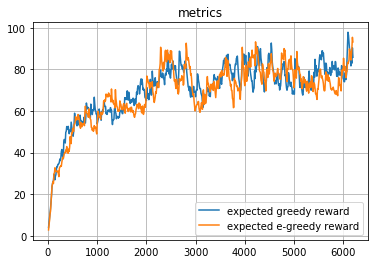

Random session examples


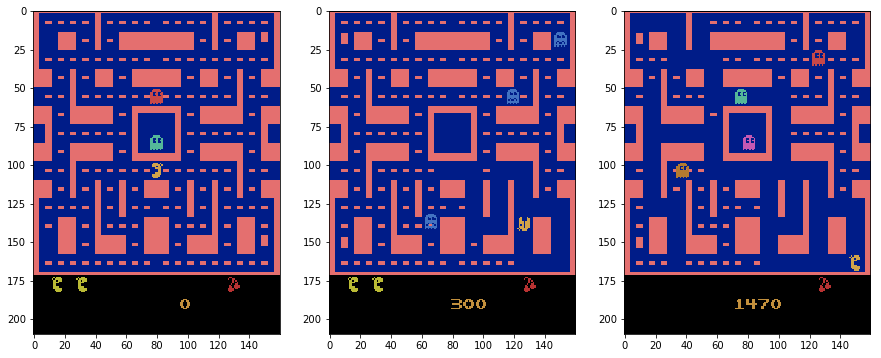

epoch 6210,loss 397.60562, epsilon 0.05090, rewards: ( e-greedy 90.50206, greedy 84.74419) 
rec 397.492 reg 0.114
epoch 6220,loss 270.27353, epsilon 0.05090, rewards: ( e-greedy 87.32685, greedy 83.08227) 
rec 270.160 reg 0.114
epoch 6230,loss 465.83037, epsilon 0.05089, rewards: ( e-greedy 85.34417, greedy 78.64904) 
rec 465.716 reg 0.114
epoch 6240,loss 574.59958, epsilon 0.05088, rewards: ( e-greedy 86.93475, greedy 84.28414) 
rec 574.486 reg 0.114
epoch 6250,loss 227.57343, epsilon 0.05087, rewards: ( e-greedy 83.61628, greedy 79.85572) 
rec 227.460 reg 0.114
epoch 6260,loss 189.96232, epsilon 0.05086, rewards: ( e-greedy 78.87965, greedy 76.62015) 
rec 189.848 reg 0.114
epoch 6270,loss 1001.43824, epsilon 0.05085, rewards: ( e-greedy 84.36668, greedy 81.95814) 
rec 1001.324 reg 0.114
epoch 6280,loss 1340.53604, epsilon 0.05084, rewards: ( e-greedy 86.30502, greedy 83.51232) 
rec 1340.422 reg 0.114
epoch 6290,loss 769.46751, epsilon 0.05083, rewards: ( e-greedy 88.29951, greedy 82.

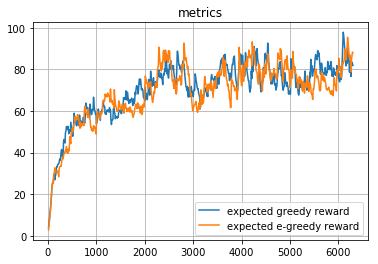

Random session examples


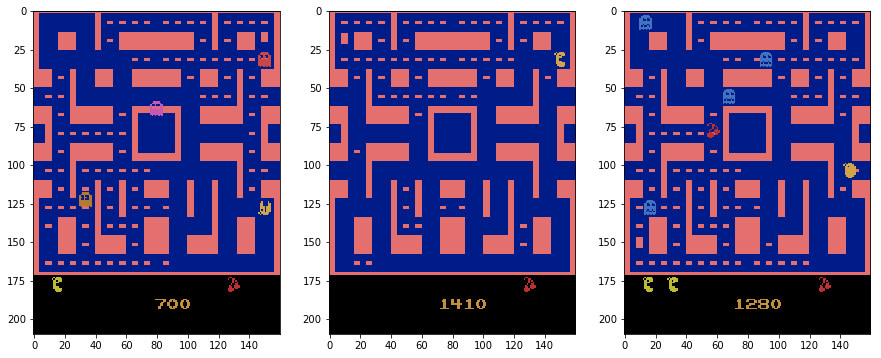

epoch 6310,loss 972.86697, epsilon 0.05082, rewards: ( e-greedy 85.36011, greedy 78.68798) 
rec 972.753 reg 0.114
epoch 6320,loss 2100.09269, epsilon 0.05081, rewards: ( e-greedy 94.26160, greedy 77.06918) 
rec 2099.978 reg 0.114
epoch 6330,loss 290.28568, epsilon 0.05080, rewards: ( e-greedy 89.71044, greedy 75.17477) 
rec 290.171 reg 0.114
epoch 6340,loss 285.11570, epsilon 0.05079, rewards: ( e-greedy 85.92689, greedy 78.53229) 
rec 285.001 reg 0.114
epoch 6350,loss 784.34360, epsilon 0.05079, rewards: ( e-greedy 85.95920, greedy 81.42906) 
rec 784.229 reg 0.114
epoch 6360,loss 250.20640, epsilon 0.05078, rewards: ( e-greedy 81.23828, greedy 78.78615) 
rec 250.092 reg 0.115
epoch 6370,loss 1831.45083, epsilon 0.05077, rewards: ( e-greedy 84.67695, greedy 79.65754) 
rec 1831.336 reg 0.115
epoch 6380,loss 614.69059, epsilon 0.05076, rewards: ( e-greedy 85.20926, greedy 75.81679) 
rec 614.576 reg 0.115
epoch 6390,loss 590.23620, epsilon 0.05076, rewards: ( e-greedy 83.93833, greedy 74.

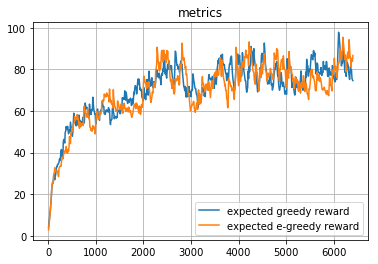

Random session examples


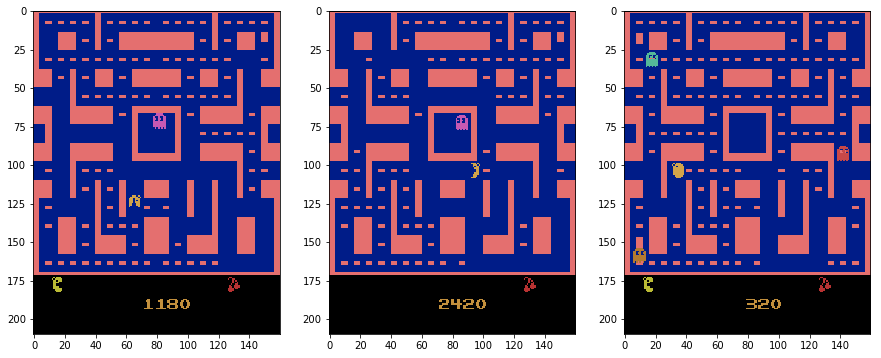

epoch 6410,loss 262.65498, epsilon 0.05074, rewards: ( e-greedy 82.93380, greedy 79.84356) 
rec 262.540 reg 0.115
epoch 6420,loss 601.62876, epsilon 0.05073, rewards: ( e-greedy 84.01542, greedy 79.04671) 
rec 601.514 reg 0.115
epoch 6430,loss 359.01625, epsilon 0.05073, rewards: ( e-greedy 81.36388, greedy 77.57953) 
rec 358.901 reg 0.115
epoch 6440,loss 662.46769, epsilon 0.05072, rewards: ( e-greedy 81.22749, greedy 77.57158) 
rec 662.353 reg 0.115
epoch 6450,loss 302.00750, epsilon 0.05071, rewards: ( e-greedy 79.41724, greedy 75.81442) 
rec 301.893 reg 0.115
epoch 6460,loss 916.84416, epsilon 0.05070, rewards: ( e-greedy 82.28802, greedy 77.60798) 
rec 916.729 reg 0.115
epoch 6470,loss 551.74996, epsilon 0.05070, rewards: ( e-greedy 80.05922, greedy 75.59718) 
rec 551.635 reg 0.115
epoch 6480,loss 357.66357, epsilon 0.05069, rewards: ( e-greedy 79.11579, greedy 76.22496) 
rec 357.549 reg 0.115
epoch 6490,loss 1468.73314, epsilon 0.05068, rewards: ( e-greedy 78.57921, greedy 74.289

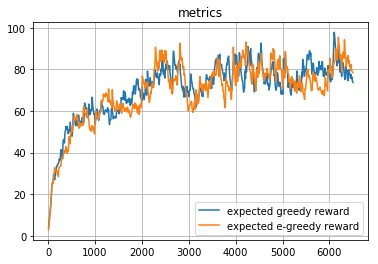

Random session examples


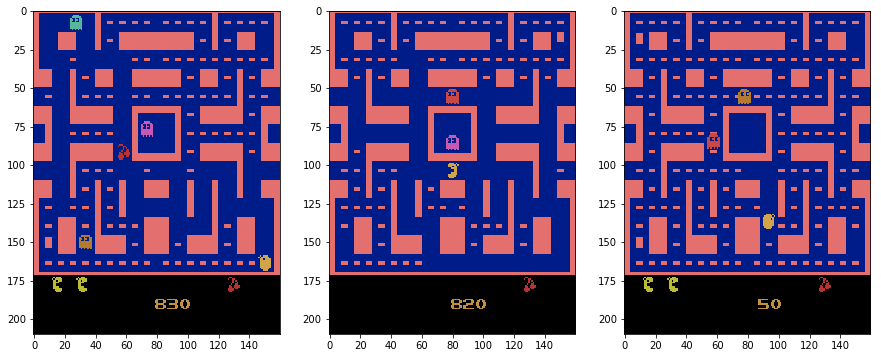

epoch 6510,loss 541.17595, epsilon 0.05067, rewards: ( e-greedy 79.68666, greedy 78.79987) 
rec 541.060 reg 0.116
epoch 6520,loss 1686.70983, epsilon 0.05066, rewards: ( e-greedy 77.90550, greedy 74.16989) 
rec 1686.594 reg 0.116
epoch 6530,loss 561.52486, epsilon 0.05066, rewards: ( e-greedy 75.55245, greedy 70.25290) 
rec 561.409 reg 0.116
epoch 6540,loss 292.82314, epsilon 0.05065, rewards: ( e-greedy 75.43470, greedy 71.22761) 
rec 292.707 reg 0.116
epoch 6550,loss 361.40297, epsilon 0.05064, rewards: ( e-greedy 72.26623, greedy 69.60485) 
rec 361.287 reg 0.116
epoch 6560,loss 1117.88033, epsilon 0.05064, rewards: ( e-greedy 73.60211, greedy 67.51936) 
rec 1117.764 reg 0.116
epoch 6570,loss 316.93114, epsilon 0.05063, rewards: ( e-greedy 75.17940, greedy 73.95493) 
rec 316.815 reg 0.116
epoch 6580,loss 858.05293, epsilon 0.05062, rewards: ( e-greedy 74.97396, greedy 71.37193) 
rec 857.937 reg 0.116
epoch 6590,loss 280.39658, epsilon 0.05062, rewards: ( e-greedy 72.66406, greedy 68.

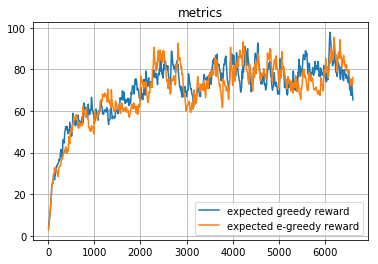

Random session examples


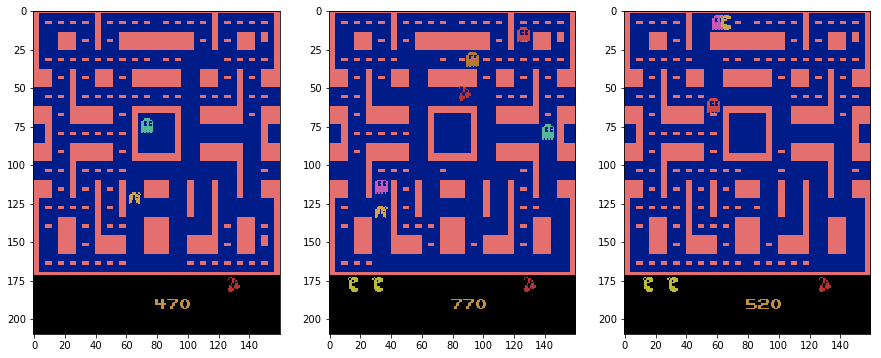

epoch 6610,loss 266.12749, epsilon 0.05061, rewards: ( e-greedy 73.22664, greedy 70.44451) 
rec 266.012 reg 0.116
epoch 6620,loss 614.92392, epsilon 0.05060, rewards: ( e-greedy 73.15398, greedy 69.46256) 
rec 614.808 reg 0.116
epoch 6630,loss 434.24663, epsilon 0.05059, rewards: ( e-greedy 72.58858, greedy 70.51631) 
rec 434.131 reg 0.116
epoch 6640,loss 423.20166, epsilon 0.05059, rewards: ( e-greedy 72.95472, greedy 70.02718) 
rec 423.086 reg 0.116
epoch 6650,loss 236.42193, epsilon 0.05058, rewards: ( e-greedy 71.72175, greedy 68.52446) 
rec 236.306 reg 0.116
epoch 6660,loss 331.62142, epsilon 0.05058, rewards: ( e-greedy 70.04957, greedy 66.73451) 
rec 331.505 reg 0.116
epoch 6670,loss 261.47690, epsilon 0.05057, rewards: ( e-greedy 68.54462, greedy 66.93606) 
rec 261.361 reg 0.116
epoch 6680,loss 226.76443, epsilon 0.05057, rewards: ( e-greedy 66.50266, greedy 64.99246) 
rec 226.648 reg 0.116
epoch 6690,loss 490.45278, epsilon 0.05056, rewards: ( e-greedy 67.22739, greedy 66.7432

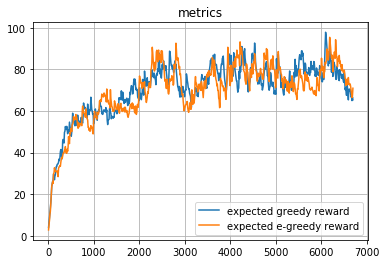

Random session examples


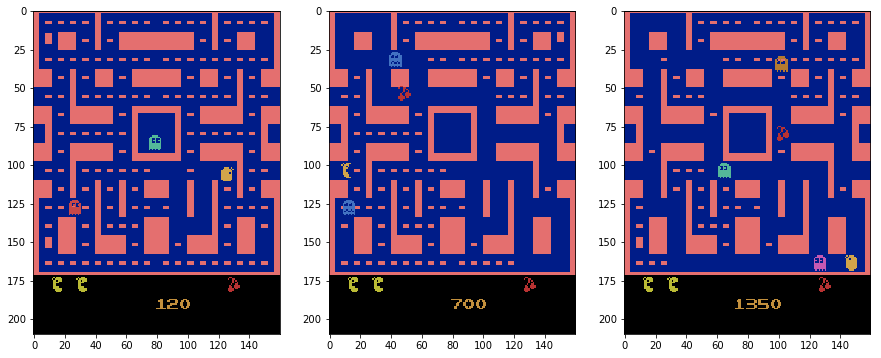

epoch 6710,loss 298.70225, epsilon 0.05055, rewards: ( e-greedy 73.16044, greedy 66.21825) 
rec 298.586 reg 0.116
epoch 6720,loss 511.13608, epsilon 0.05054, rewards: ( e-greedy 69.84439, greedy 64.28392) 
rec 511.020 reg 0.116
epoch 6730,loss 927.18273, epsilon 0.05054, rewards: ( e-greedy 72.79745, greedy 65.85553) 
rec 927.066 reg 0.116
epoch 6740,loss 829.54258, epsilon 0.05053, rewards: ( e-greedy 76.39271, greedy 73.58248) 
rec 829.426 reg 0.116
epoch 6750,loss 1396.85840, epsilon 0.05053, rewards: ( e-greedy 78.75344, greedy 73.22423) 
rec 1396.742 reg 0.117
epoch 6760,loss 983.29289, epsilon 0.05052, rewards: ( e-greedy 78.62809, greedy 75.46431) 
rec 983.176 reg 0.117
epoch 6770,loss 889.57109, epsilon 0.05052, rewards: ( e-greedy 81.26528, greedy 78.79288) 
rec 889.454 reg 0.117
epoch 6780,loss 264.58839, epsilon 0.05051, rewards: ( e-greedy 79.38876, greedy 84.47609) 
rec 264.472 reg 0.117
epoch 6790,loss 818.55259, epsilon 0.05051, rewards: ( e-greedy 80.57488, greedy 81.46

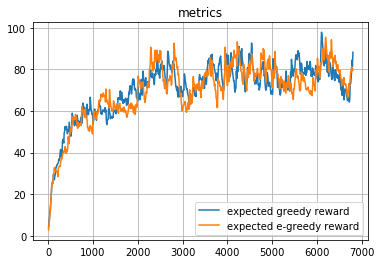

Random session examples


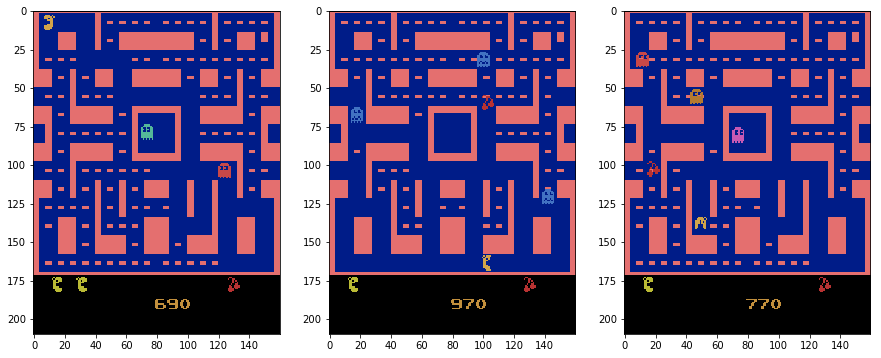

epoch 6810,loss 2307.48752, epsilon 0.05050, rewards: ( e-greedy 82.31565, greedy 89.43119) 
rec 2307.371 reg 0.117
epoch 6820,loss 1117.31204, epsilon 0.05049, rewards: ( e-greedy 85.52159, greedy 89.23807) 
rec 1117.195 reg 0.117
epoch 6830,loss 179.61700, epsilon 0.05049, rewards: ( e-greedy 79.34443, greedy 86.56427) 
rec 179.500 reg 0.117
epoch 6840,loss 294.40708, epsilon 0.05048, rewards: ( e-greedy 78.22249, greedy 87.72034) 
rec 294.290 reg 0.117
epoch 6850,loss 1680.34476, epsilon 0.05048, rewards: ( e-greedy 84.33774, greedy 83.94831) 
rec 1680.228 reg 0.117
epoch 6860,loss 826.66980, epsilon 0.05047, rewards: ( e-greedy 85.71646, greedy 89.24098) 
rec 826.553 reg 0.117
epoch 6870,loss 289.38995, epsilon 0.05047, rewards: ( e-greedy 81.33232, greedy 87.25438) 
rec 289.273 reg 0.117
epoch 6880,loss 278.84123, epsilon 0.05046, rewards: ( e-greedy 79.82409, greedy 83.34144) 
rec 278.724 reg 0.117
epoch 6890,loss 1676.64939, epsilon 0.05046, rewards: ( e-greedy 81.27918, greedy 

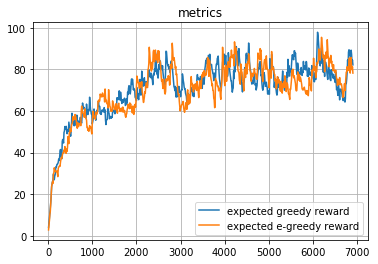

Random session examples


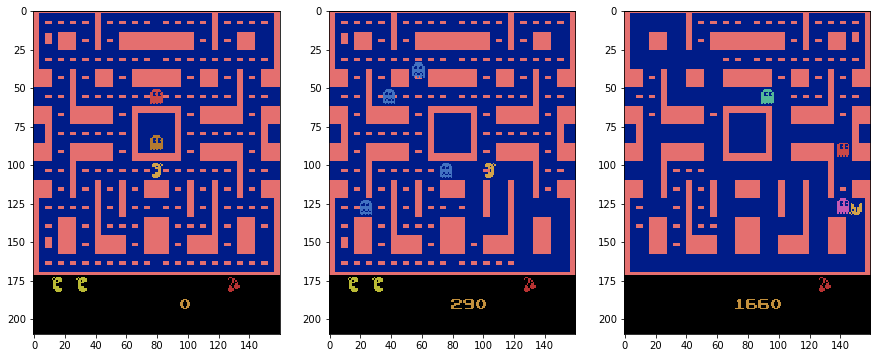

epoch 6910,loss 2177.74419, epsilon 0.05045, rewards: ( e-greedy 81.64238, greedy 82.90654) 
rec 2177.627 reg 0.117
epoch 6920,loss 251.21249, epsilon 0.05044, rewards: ( e-greedy 80.10314, greedy 83.30338) 
rec 251.095 reg 0.117
epoch 6930,loss 278.89267, epsilon 0.05044, rewards: ( e-greedy 78.71783, greedy 83.66054) 
rec 278.776 reg 0.117
epoch 6940,loss 220.17750, epsilon 0.05044, rewards: ( e-greedy 75.90855, greedy 78.98199) 
rec 220.060 reg 0.117
epoch 6950,loss 427.88512, epsilon 0.05043, rewards: ( e-greedy 73.94269, greedy 78.77129) 
rec 427.768 reg 0.117
epoch 6960,loss 1196.83058, epsilon 0.05043, rewards: ( e-greedy 75.67342, greedy 79.45666) 
rec 1196.713 reg 0.117
epoch 6970,loss 4294.99723, epsilon 0.05042, rewards: ( e-greedy 84.29358, greedy 81.63600) 
rec 4294.880 reg 0.117
epoch 6980,loss 327.60688, epsilon 0.05042, rewards: ( e-greedy 85.36422, greedy 88.78490) 
rec 327.490 reg 0.117
epoch 6990,loss 203.63514, epsilon 0.05041, rewards: ( e-greedy 81.76530, greedy 8

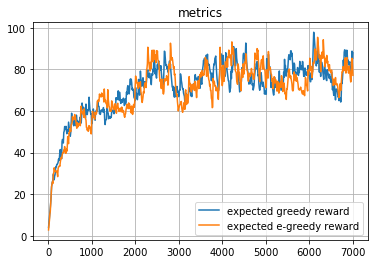

Random session examples


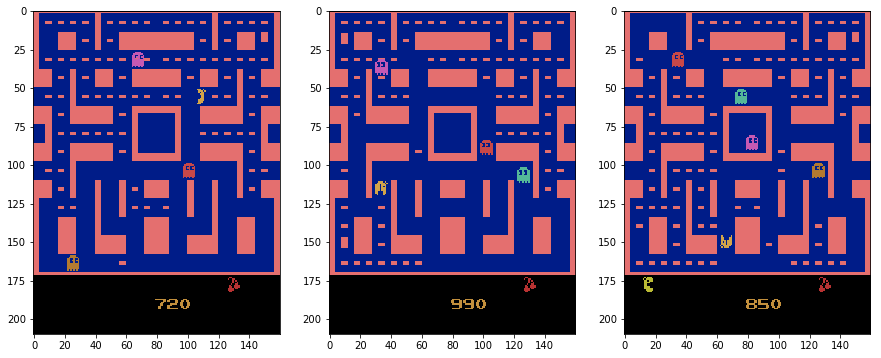

[2017-05-25 02:18:48,213] Making new env: MsPacman-v0
[2017-05-25 02:18:48,388] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 02:18:48,397] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.9.25470.video000000.mp4
[2017-05-25 02:18:51,644] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.9.25470.video000001.mp4


Episode finished after 660 timesteps with reward=180.0
Episode finished after 952 timesteps with reward=510.0
Episode finished after 880 timesteps with reward=440.0
Episode finished after 630 timesteps with reward=180.0
Episode finished after 619 timesteps with reward=110.0
Episode finished after 868 timesteps with reward=450.0
Episode finished after 879 timesteps with reward=450.0


[2017-05-25 02:19:16,661] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.9.25470.video000008.mp4


Episode finished after 608 timesteps with reward=180.0
Episode finished after 722 timesteps with reward=530.0
Episode finished after 967 timesteps with reward=440.0
Episode finished after 605 timesteps with reward=100.0
Episode finished after 603 timesteps with reward=140.0
Episode finished after 643 timesteps with reward=110.0
Episode finished after 861 timesteps with reward=500.0
Episode finished after 895 timesteps with reward=440.0
Episode finished after 1254 timesteps with reward=840.0
Episode finished after 622 timesteps with reward=70.0
Episode finished after 761 timesteps with reward=240.0
Episode finished after 934 timesteps with reward=240.0


[2017-05-25 02:19:59,627] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')


Episode finished after 726 timesteps with reward=240.0
Mean 319.5, Var 38474.75
epoch 7010,loss 1481.44710, epsilon 0.05041, rewards: ( e-greedy 80.24864, greedy 86.79419) 
rec 1481.330 reg 0.117
epoch 7020,loss 256.58289, epsilon 0.05040, rewards: ( e-greedy 78.16128, greedy 85.61477) 
rec 256.466 reg 0.117
epoch 7030,loss 271.49139, epsilon 0.05040, rewards: ( e-greedy 74.53265, greedy 83.05329) 
rec 271.374 reg 0.117
epoch 7040,loss 1598.95827, epsilon 0.05039, rewards: ( e-greedy 76.01689, greedy 85.18546) 
rec 1598.841 reg 0.117
epoch 7050,loss 773.53602, epsilon 0.05039, rewards: ( e-greedy 78.16520, greedy 85.10442) 
rec 773.419 reg 0.117
epoch 7060,loss 1450.68481, epsilon 0.05039, rewards: ( e-greedy 80.03618, greedy 81.78148) 
rec 1450.567 reg 0.117
epoch 7070,loss 257.13743, epsilon 0.05038, rewards: ( e-greedy 76.84506, greedy 82.04083) 
rec 257.020 reg 0.117
epoch 7080,loss 1151.75957, epsilon 0.05038, rewards: ( e-greedy 78.66055, greedy 79.96175) 
rec 1151.642 reg 0.117


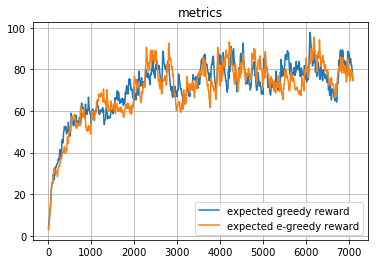

Random session examples


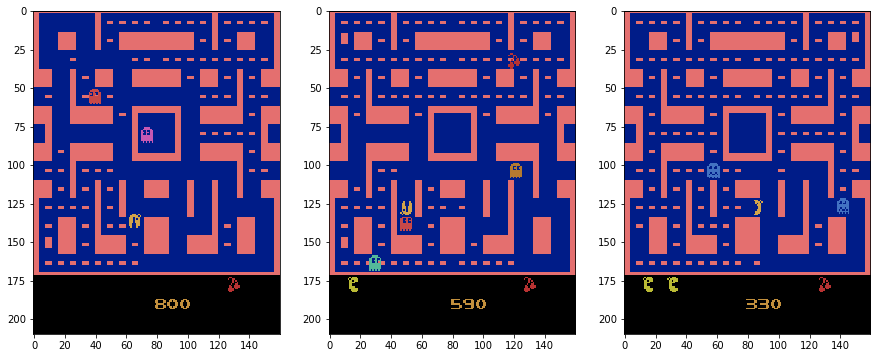

epoch 7110,loss 205.28612, epsilon 0.05037, rewards: ( e-greedy 72.38729, greedy 72.04524) 
rec 205.169 reg 0.117
epoch 7120,loss 289.76116, epsilon 0.05036, rewards: ( e-greedy 69.71106, greedy 70.96571) 
rec 289.644 reg 0.118
epoch 7130,loss 246.38425, epsilon 0.05036, rewards: ( e-greedy 66.55246, greedy 67.68164) 
rec 246.267 reg 0.118
epoch 7140,loss 1383.39323, epsilon 0.05036, rewards: ( e-greedy 69.64721, greedy 65.53848) 
rec 1383.276 reg 0.118
epoch 7150,loss 1809.79311, epsilon 0.05035, rewards: ( e-greedy 73.80749, greedy 65.67213) 
rec 1809.675 reg 0.118
epoch 7160,loss 477.18824, epsilon 0.05035, rewards: ( e-greedy 72.48924, greedy 64.41742) 
rec 477.071 reg 0.118
epoch 7170,loss 1255.73957, epsilon 0.05035, rewards: ( e-greedy 73.17782, greedy 66.66318) 
rec 1255.622 reg 0.118
epoch 7180,loss 384.50056, epsilon 0.05034, rewards: ( e-greedy 73.98504, greedy 70.99686) 
rec 384.383 reg 0.118
epoch 7190,loss 394.55818, epsilon 0.05034, rewards: ( e-greedy 72.39903, greedy 7

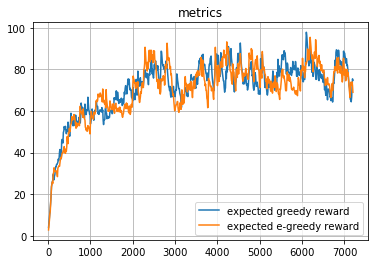

Random session examples


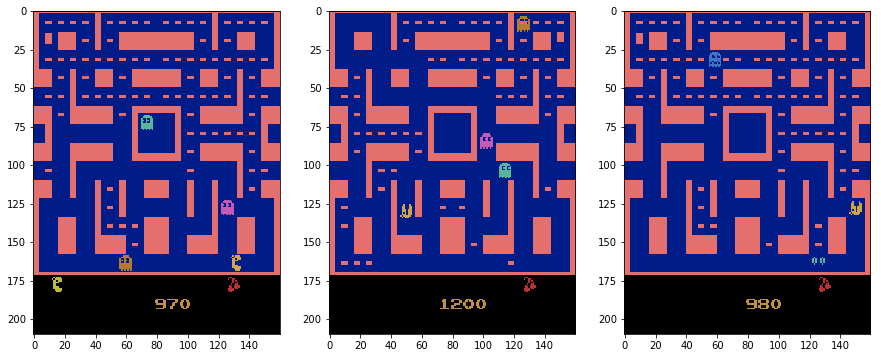

epoch 7210,loss 1722.92094, epsilon 0.05033, rewards: ( e-greedy 75.88697, greedy 71.80983) 
rec 1722.803 reg 0.118
epoch 7220,loss 273.78356, epsilon 0.05033, rewards: ( e-greedy 73.79827, greedy 72.75385) 
rec 273.666 reg 0.118
epoch 7230,loss 5262.14746, epsilon 0.05033, rewards: ( e-greedy 82.79344, greedy 73.60347) 
rec 5262.030 reg 0.118
epoch 7240,loss 219.08088, epsilon 0.05032, rewards: ( e-greedy 79.76410, greedy 72.36812) 
rec 218.963 reg 0.118
epoch 7250,loss 526.73529, epsilon 0.05032, rewards: ( e-greedy 77.85019, greedy 70.00631) 
rec 526.617 reg 0.118
epoch 7260,loss 215.92378, epsilon 0.05032, rewards: ( e-greedy 73.81517, greedy 67.75568) 
rec 215.806 reg 0.118
epoch 7270,loss 269.44570, epsilon 0.05031, rewards: ( e-greedy 71.80865, greedy 73.85511) 
rec 269.328 reg 0.118
epoch 7280,loss 1357.39004, epsilon 0.05031, rewards: ( e-greedy 73.50279, greedy 71.46960) 
rec 1357.272 reg 0.118
epoch 7290,loss 690.10387, epsilon 0.05031, rewards: ( e-greedy 72.90251, greedy 7

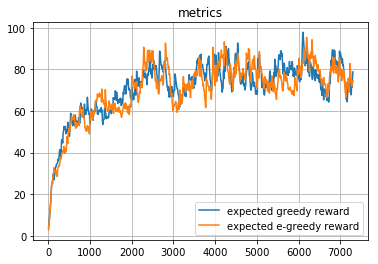

Random session examples


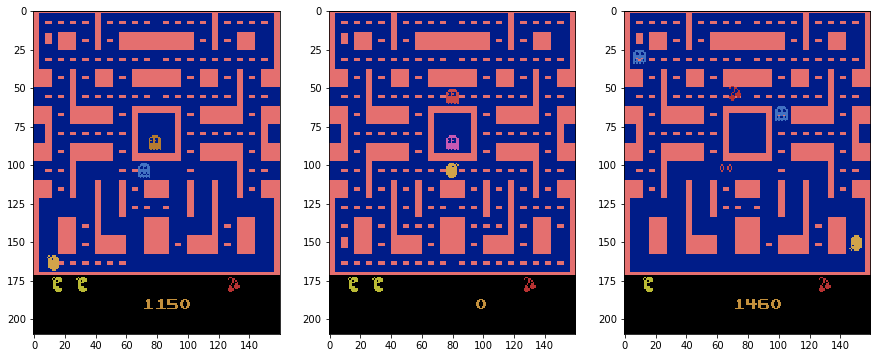

epoch 7310,loss 2372.63041, epsilon 0.05030, rewards: ( e-greedy 78.03853, greedy 77.16134) 
rec 2372.512 reg 0.118
epoch 7320,loss 528.10538, epsilon 0.05030, rewards: ( e-greedy 75.67218, greedy 76.13270) 
rec 527.987 reg 0.118
epoch 7330,loss 2230.38224, epsilon 0.05030, rewards: ( e-greedy 78.54246, greedy 80.26943) 
rec 2230.264 reg 0.118
epoch 7340,loss 643.57030, epsilon 0.05029, rewards: ( e-greedy 79.87571, greedy 76.80499) 
rec 643.452 reg 0.118
epoch 7350,loss 1087.22581, epsilon 0.05029, rewards: ( e-greedy 81.95064, greedy 83.93699) 
rec 1087.107 reg 0.119
epoch 7360,loss 1906.10312, epsilon 0.05029, rewards: ( e-greedy 81.88058, greedy 85.23079) 
rec 1905.984 reg 0.119
epoch 7370,loss 635.07481, epsilon 0.05028, rewards: ( e-greedy 80.81752, greedy 83.27021) 
rec 634.956 reg 0.119
epoch 7380,loss 373.17164, epsilon 0.05028, rewards: ( e-greedy 79.23577, greedy 84.06819) 
rec 373.053 reg 0.119
epoch 7390,loss 1235.35637, epsilon 0.05028, rewards: ( e-greedy 82.93719, greed

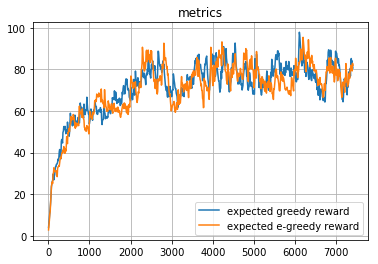

Random session examples


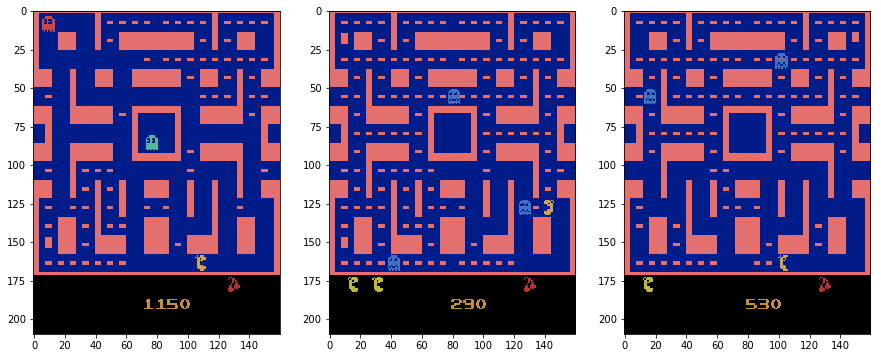

epoch 7410,loss 1152.93532, epsilon 0.05027, rewards: ( e-greedy 80.19163, greedy 79.15446) 
rec 1152.817 reg 0.119
epoch 7420,loss 395.86693, epsilon 0.05027, rewards: ( e-greedy 77.98496, greedy 80.98902) 
rec 395.748 reg 0.119
epoch 7430,loss 798.74725, epsilon 0.05027, rewards: ( e-greedy 78.43647, greedy 82.39011) 
rec 798.629 reg 0.119
epoch 7440,loss 309.22822, epsilon 0.05026, rewards: ( e-greedy 77.28032, greedy 85.27610) 
rec 309.109 reg 0.119
epoch 7450,loss 529.39198, epsilon 0.05026, rewards: ( e-greedy 81.05229, greedy 86.43599) 
rec 529.273 reg 0.119
epoch 7460,loss 324.49671, epsilon 0.05026, rewards: ( e-greedy 78.07206, greedy 84.47989) 
rec 324.378 reg 0.119
epoch 7470,loss 757.41923, epsilon 0.05026, rewards: ( e-greedy 79.88985, greedy 84.96940) 
rec 757.300 reg 0.119
epoch 7480,loss 315.55529, epsilon 0.05025, rewards: ( e-greedy 77.96337, greedy 86.97246) 
rec 315.437 reg 0.119
epoch 7490,loss 580.79347, epsilon 0.05025, rewards: ( e-greedy 77.60453, greedy 82.02

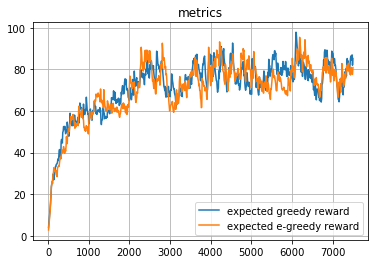

Random session examples


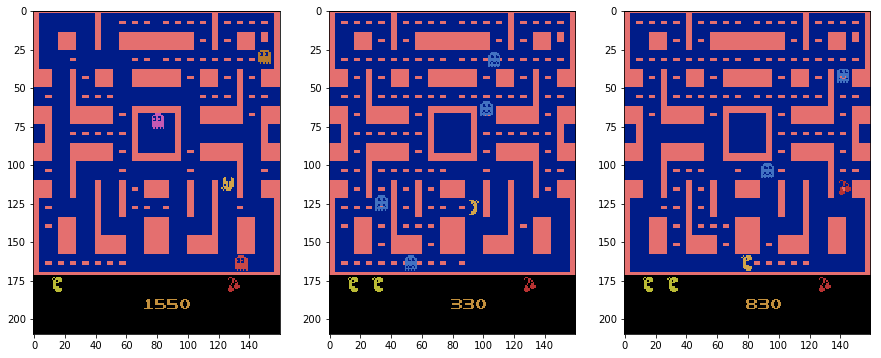

epoch 7510,loss 1078.23388, epsilon 0.05025, rewards: ( e-greedy 86.00342, greedy 89.54668) 
rec 1078.115 reg 0.119
epoch 7520,loss 454.29913, epsilon 0.05024, rewards: ( e-greedy 86.46558, greedy 91.59201) 
rec 454.180 reg 0.119
epoch 7530,loss 373.31916, epsilon 0.05024, rewards: ( e-greedy 86.00652, greedy 90.43281) 
rec 373.200 reg 0.119
epoch 7540,loss 268.94384, epsilon 0.05024, rewards: ( e-greedy 83.90587, greedy 93.38953) 
rec 268.825 reg 0.119
epoch 7550,loss 470.89143, epsilon 0.05024, rewards: ( e-greedy 83.26528, greedy 89.30057) 
rec 470.772 reg 0.119
epoch 7560,loss 567.61715, epsilon 0.05023, rewards: ( e-greedy 82.68875, greedy 86.93302) 
rec 567.498 reg 0.119
epoch 7570,loss 269.62602, epsilon 0.05023, rewards: ( e-greedy 79.48238, greedy 84.30221) 
rec 269.507 reg 0.119
epoch 7580,loss 582.33095, epsilon 0.05023, rewards: ( e-greedy 82.97164, greedy 86.05949) 
rec 582.212 reg 0.119
epoch 7590,loss 828.51906, epsilon 0.05023, rewards: ( e-greedy 82.67448, greedy 87.70

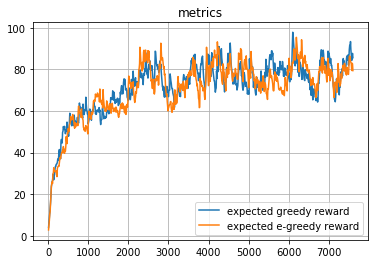

Random session examples


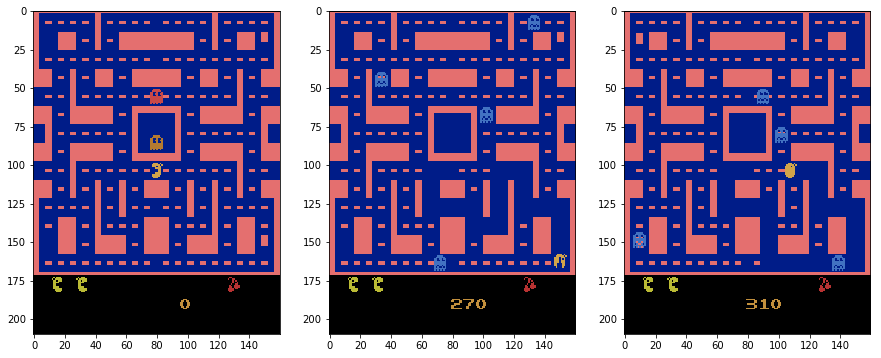

epoch 7610,loss 222.96653, epsilon 0.05022, rewards: ( e-greedy 74.71633, greedy 84.68362) 
rec 222.847 reg 0.119
epoch 7620,loss 513.33715, epsilon 0.05022, rewards: ( e-greedy 75.30719, greedy 82.34026) 
rec 513.218 reg 0.120
epoch 7630,loss 217.21954, epsilon 0.05022, rewards: ( e-greedy 73.27647, greedy 84.73123) 
rec 217.100 reg 0.120
epoch 7640,loss 1487.92875, epsilon 0.05022, rewards: ( e-greedy 79.51133, greedy 96.63311) 
rec 1487.809 reg 0.120
epoch 7650,loss 295.45236, epsilon 0.05021, rewards: ( e-greedy 76.93519, greedy 94.09480) 
rec 295.333 reg 0.120
epoch 7660,loss 1305.97661, epsilon 0.05021, rewards: ( e-greedy 78.30417, greedy 93.87282) 
rec 1305.857 reg 0.120
epoch 7670,loss 10924.85599, epsilon 0.05021, rewards: ( e-greedy 91.66126, greedy 92.92304) 
rec 10924.736 reg 0.120
epoch 7680,loss 357.56479, epsilon 0.05021, rewards: ( e-greedy 89.80763, greedy 92.88073) 
rec 357.445 reg 0.120
epoch 7690,loss 306.22794, epsilon 0.05021, rewards: ( e-greedy 86.20187, greedy

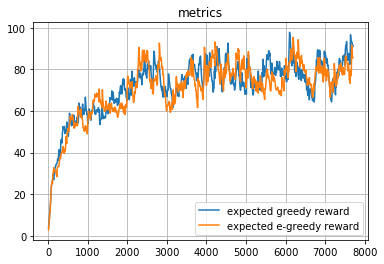

Random session examples


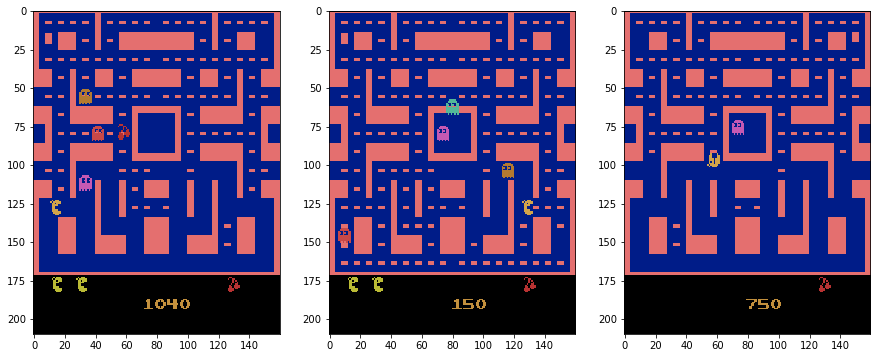

epoch 7710,loss 233.32065, epsilon 0.05020, rewards: ( e-greedy 82.27976, greedy 92.06818) 
rec 233.201 reg 0.120
epoch 7720,loss 325.05845, epsilon 0.05020, rewards: ( e-greedy 79.17679, greedy 88.04886) 
rec 324.938 reg 0.120
epoch 7730,loss 321.56189, epsilon 0.05020, rewards: ( e-greedy 78.88411, greedy 86.55648) 
rec 321.442 reg 0.120
epoch 7740,loss 1567.71790, epsilon 0.05020, rewards: ( e-greedy 82.37070, greedy 84.33833) 
rec 1567.598 reg 0.120
epoch 7750,loss 303.00031, epsilon 0.05019, rewards: ( e-greedy 81.63363, greedy 83.59200) 
rec 302.880 reg 0.120
epoch 7760,loss 1323.79535, epsilon 0.05019, rewards: ( e-greedy 81.22026, greedy 79.98280) 
rec 1323.675 reg 0.120
epoch 7770,loss 3218.29782, epsilon 0.05019, rewards: ( e-greedy 84.22324, greedy 82.54702) 
rec 3218.177 reg 0.120
epoch 7780,loss 1444.38018, epsilon 0.05019, rewards: ( e-greedy 87.17591, greedy 83.41731) 
rec 1444.260 reg 0.120
epoch 7790,loss 237.32609, epsilon 0.05019, rewards: ( e-greedy 83.39582, greedy

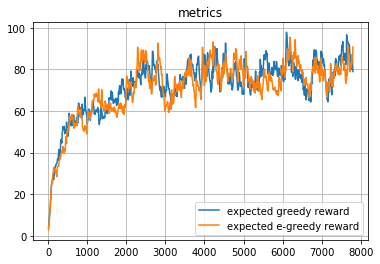

Random session examples


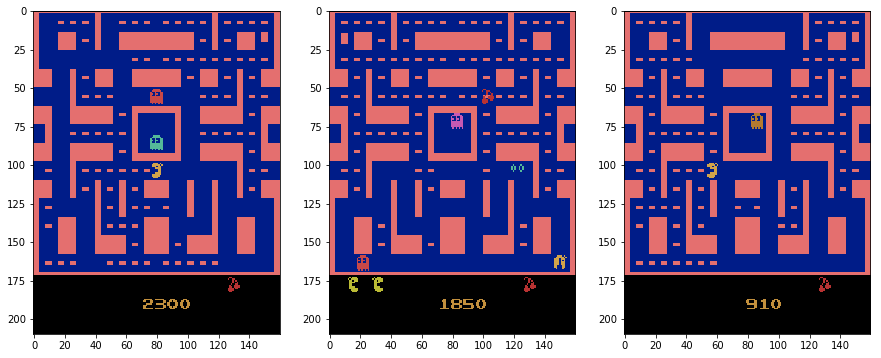

epoch 7810,loss 340.34897, epsilon 0.05018, rewards: ( e-greedy 89.85062, greedy 81.57685) 
rec 340.228 reg 0.121
epoch 7820,loss 556.76049, epsilon 0.05018, rewards: ( e-greedy 87.49056, greedy 79.66916) 
rec 556.640 reg 0.121
epoch 7830,loss 1772.63527, epsilon 0.05018, rewards: ( e-greedy 84.92900, greedy 78.32725) 
rec 1772.514 reg 0.121
epoch 7840,loss 315.76769, epsilon 0.05018, rewards: ( e-greedy 80.06110, greedy 74.68202) 
rec 315.647 reg 0.121
epoch 7850,loss 622.03000, epsilon 0.05018, rewards: ( e-greedy 80.17999, greedy 76.08882) 
rec 621.909 reg 0.121
epoch 7860,loss 284.40686, epsilon 0.05017, rewards: ( e-greedy 80.47449, greedy 80.60494) 
rec 284.286 reg 0.121
epoch 7870,loss 306.18715, epsilon 0.05017, rewards: ( e-greedy 77.73954, greedy 76.73194) 
rec 306.066 reg 0.121
epoch 7880,loss 315.63905, epsilon 0.05017, rewards: ( e-greedy 77.21559, greedy 73.74625) 
rec 315.518 reg 0.121
epoch 7890,loss 456.27862, epsilon 0.05017, rewards: ( e-greedy 78.24403, greedy 78.68

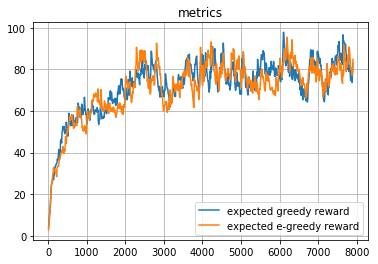

Random session examples


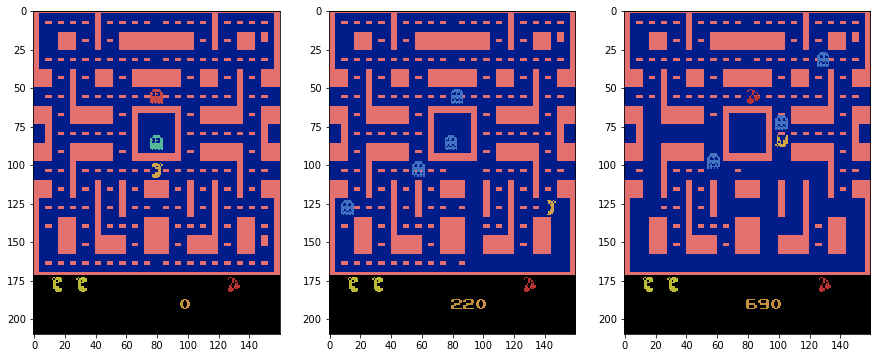

epoch 7910,loss 268.14142, epsilon 0.05017, rewards: ( e-greedy 79.93391, greedy 80.65289) 
rec 268.020 reg 0.122
epoch 7920,loss 579.45766, epsilon 0.05016, rewards: ( e-greedy 78.25302, greedy 78.71260) 
rec 579.336 reg 0.121
epoch 7930,loss 9228.62822, epsilon 0.05016, rewards: ( e-greedy 92.30272, greedy 80.02884) 
rec 9228.507 reg 0.121
epoch 7940,loss 263.17310, epsilon 0.05016, rewards: ( e-greedy 87.44745, greedy 80.83846) 
rec 263.052 reg 0.122
epoch 7950,loss 327.86630, epsilon 0.05016, rewards: ( e-greedy 84.76520, greedy 78.62961) 
rec 327.745 reg 0.122
epoch 7960,loss 7331.25681, epsilon 0.05016, rewards: ( e-greedy 96.16368, greedy 81.82915) 
rec 7331.135 reg 0.122
epoch 7970,loss 248.78654, epsilon 0.05016, rewards: ( e-greedy 91.29731, greedy 78.83374) 
rec 248.665 reg 0.122
epoch 7980,loss 667.93061, epsilon 0.05015, rewards: ( e-greedy 88.54258, greedy 80.07536) 
rec 667.809 reg 0.122
epoch 7990,loss 295.08491, epsilon 0.05015, rewards: ( e-greedy 87.06332, greedy 83.

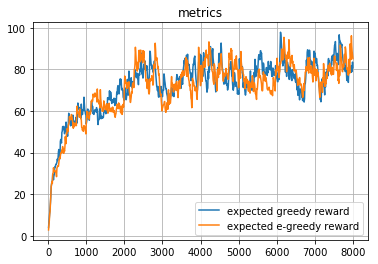

Random session examples


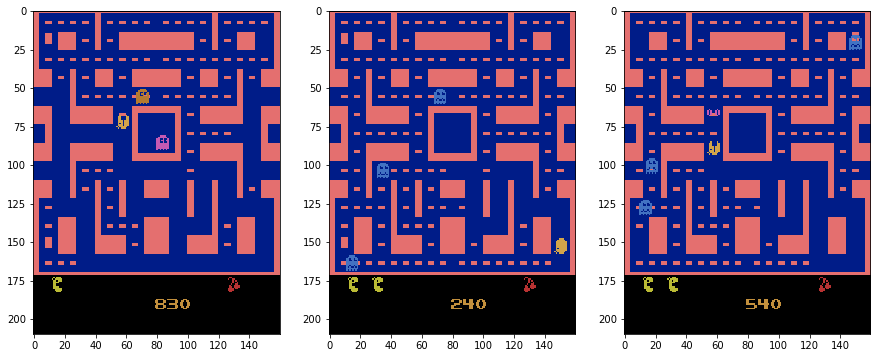

[2017-05-25 03:55:42,514] Making new env: MsPacman-v0
[2017-05-25 03:55:42,690] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 03:55:42,699] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.10.25470.video000000.mp4
[2017-05-25 03:55:49,707] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.10.25470.video000001.mp4


Episode finished after 1198 timesteps with reward=1720.0
Episode finished after 879 timesteps with reward=440.0
Episode finished after 748 timesteps with reward=430.0
Episode finished after 881 timesteps with reward=850.0
Episode finished after 1051 timesteps with reward=450.0
Episode finished after 716 timesteps with reward=150.0
Episode finished after 857 timesteps with reward=450.0


[2017-05-25 03:56:18,000] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.10.25470.video000008.mp4


Episode finished after 1282 timesteps with reward=440.0
Episode finished after 1182 timesteps with reward=240.0
Episode finished after 965 timesteps with reward=840.0
Episode finished after 868 timesteps with reward=840.0
Episode finished after 916 timesteps with reward=240.0
Episode finished after 812 timesteps with reward=450.0
Episode finished after 643 timesteps with reward=200.0
Episode finished after 889 timesteps with reward=840.0
Episode finished after 987 timesteps with reward=440.0
Episode finished after 966 timesteps with reward=240.0
Episode finished after 830 timesteps with reward=240.0
Episode finished after 1046 timesteps with reward=250.0


[2017-05-25 03:57:06,932] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')


Episode finished after 965 timesteps with reward=250.0
Mean 500.0, Var 129440.0
epoch 8010,loss 246.56559, epsilon 0.05015, rewards: ( e-greedy 83.40254, greedy 80.57681) 
rec 246.444 reg 0.122
epoch 8020,loss 677.40706, epsilon 0.05015, rewards: ( e-greedy 83.62479, greedy 78.26913) 
rec 677.285 reg 0.122
epoch 8030,loss 355.24842, epsilon 0.05015, rewards: ( e-greedy 80.07481, greedy 75.69222) 
rec 355.127 reg 0.122
epoch 8040,loss 222.61751, epsilon 0.05015, rewards: ( e-greedy 76.81733, greedy 75.49800) 
rec 222.495 reg 0.122
epoch 8050,loss 536.01997, epsilon 0.05014, rewards: ( e-greedy 75.26060, greedy 77.51070) 
rec 535.898 reg 0.122
epoch 8060,loss 1919.43675, epsilon 0.05014, rewards: ( e-greedy 76.54704, greedy 74.50963) 
rec 1919.315 reg 0.122
epoch 8070,loss 652.45786, epsilon 0.05014, rewards: ( e-greedy 77.70483, greedy 72.87117) 
rec 652.336 reg 0.122
epoch 8080,loss 265.22991, epsilon 0.05014, rewards: ( e-greedy 75.05935, greedy 75.08405) 
rec 265.108 reg 0.122
epoch 

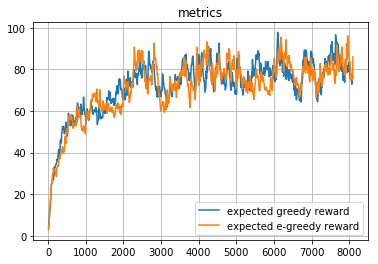

Random session examples


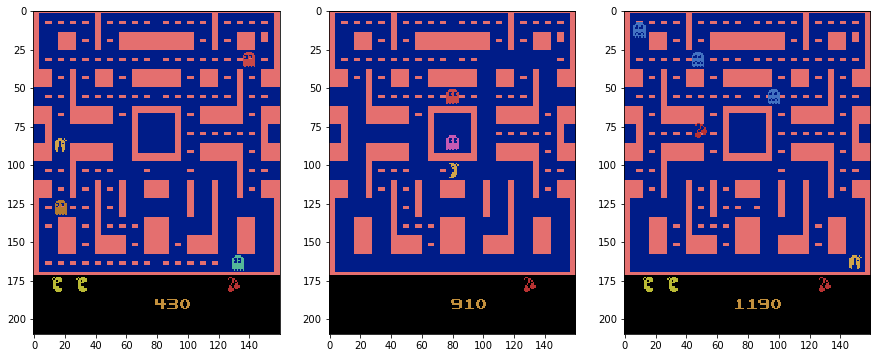

epoch 8110,loss 645.05943, epsilon 0.05014, rewards: ( e-greedy 84.25639, greedy 83.50002) 
rec 644.937 reg 0.122
epoch 8120,loss 4633.90371, epsilon 0.05013, rewards: ( e-greedy 89.76825, greedy 93.90002) 
rec 4633.781 reg 0.122
epoch 8130,loss 221.71234, epsilon 0.05013, rewards: ( e-greedy 85.60393, greedy 92.76002) 
rec 221.590 reg 0.122
epoch 8140,loss 422.75071, epsilon 0.05013, rewards: ( e-greedy 82.41853, greedy 89.23402) 
rec 422.628 reg 0.122
epoch 8150,loss 4354.29465, epsilon 0.05013, rewards: ( e-greedy 89.48918, greedy 91.62311) 
rec 4354.172 reg 0.122
epoch 8160,loss 2719.90844, epsilon 0.05013, rewards: ( e-greedy 96.04026, greedy 88.27330) 
rec 2719.786 reg 0.122
epoch 8170,loss 380.80318, epsilon 0.05013, rewards: ( e-greedy 90.81124, greedy 83.00847) 
rec 380.681 reg 0.123
epoch 8180,loss 1383.22168, epsilon 0.05013, rewards: ( e-greedy 93.54261, greedy 85.20763) 
rec 1383.099 reg 0.123
epoch 8190,loss 377.47381, epsilon 0.05012, rewards: ( e-greedy 90.87585, greedy

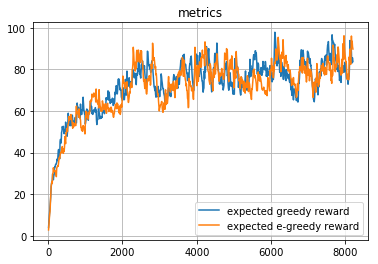

Random session examples


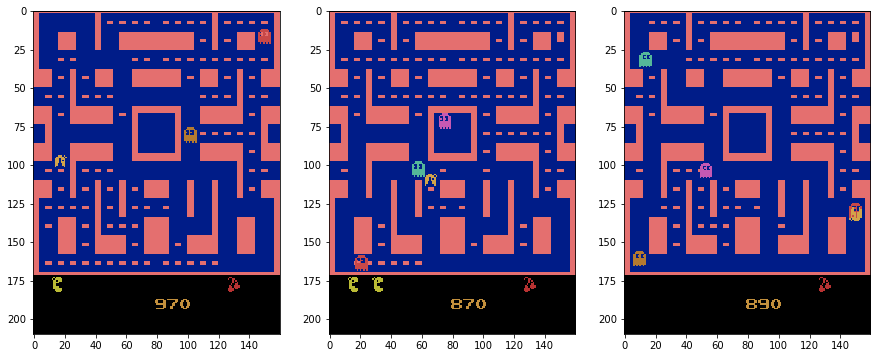

epoch 8210,loss 652.81389, epsilon 0.05012, rewards: ( e-greedy 90.74694, greedy 81.19261) 
rec 652.691 reg 0.123
epoch 8220,loss 880.77832, epsilon 0.05012, rewards: ( e-greedy 90.92225, greedy 81.82335) 
rec 880.656 reg 0.123
epoch 8230,loss 386.76898, epsilon 0.05012, rewards: ( e-greedy 87.89252, greedy 86.26601) 
rec 386.646 reg 0.123
epoch 8240,loss 343.41696, epsilon 0.05012, rewards: ( e-greedy 83.91577, greedy 81.26441) 
rec 343.294 reg 0.123
epoch 8250,loss 276.56487, epsilon 0.05012, rewards: ( e-greedy 81.64919, greedy 78.57547) 
rec 276.442 reg 0.123
epoch 8260,loss 443.67143, epsilon 0.05012, rewards: ( e-greedy 81.17177, greedy 74.78042) 
rec 443.549 reg 0.123
epoch 8270,loss 569.54944, epsilon 0.05012, rewards: ( e-greedy 78.61710, greedy 72.73988) 
rec 569.426 reg 0.123
epoch 8280,loss 1911.08069, epsilon 0.05011, rewards: ( e-greedy 80.38039, greedy 73.34089) 
rec 1910.958 reg 0.123
epoch 8290,loss 287.35862, epsilon 0.05011, rewards: ( e-greedy 76.46735, greedy 71.25

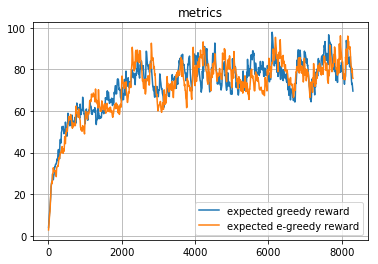

Random session examples


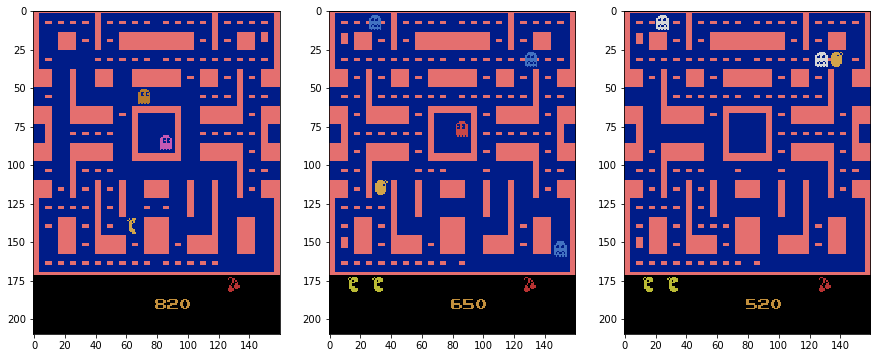

epoch 8310,loss 1060.70126, epsilon 0.05011, rewards: ( e-greedy 79.93855, greedy 68.92426) 
rec 1060.578 reg 0.123
epoch 8320,loss 445.99234, epsilon 0.05011, rewards: ( e-greedy 78.19470, greedy 65.84433) 
rec 445.869 reg 0.123
epoch 8330,loss 379.70908, epsilon 0.05011, rewards: ( e-greedy 74.18773, greedy 69.82240) 
rec 379.586 reg 0.123
epoch 8340,loss 668.15872, epsilon 0.05011, rewards: ( e-greedy 73.39395, greedy 72.96516) 
rec 668.036 reg 0.123
epoch 8350,loss 333.91358, epsilon 0.05011, rewards: ( e-greedy 70.24206, greedy 70.98115) 
rec 333.791 reg 0.123
epoch 8360,loss 979.32393, epsilon 0.05011, rewards: ( e-greedy 74.78035, greedy 76.44553) 
rec 979.201 reg 0.123
epoch 8370,loss 170.05539, epsilon 0.05010, rewards: ( e-greedy 69.92732, greedy 75.61348) 
rec 169.932 reg 0.123
epoch 8380,loss 5666.96400, epsilon 0.05010, rewards: ( e-greedy 76.43459, greedy 80.48963) 
rec 5666.841 reg 0.123
epoch 8390,loss 1258.11616, epsilon 0.05010, rewards: ( e-greedy 82.41613, greedy 87

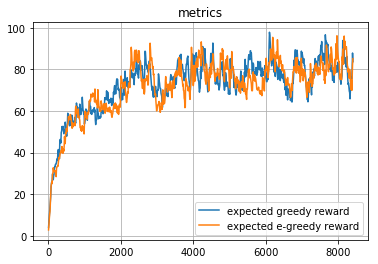

Random session examples


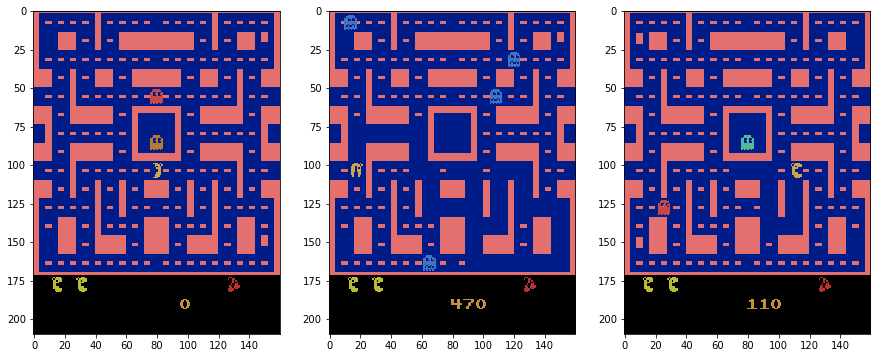

epoch 8410,loss 475.95507, epsilon 0.05010, rewards: ( e-greedy 83.65706, greedy 82.78132) 
rec 475.831 reg 0.124
epoch 8420,loss 330.15921, epsilon 0.05010, rewards: ( e-greedy 80.16636, greedy 86.06568) 
rec 330.035 reg 0.124
epoch 8430,loss 1005.62444, epsilon 0.05010, rewards: ( e-greedy 80.77472, greedy 81.64662) 
rec 1005.501 reg 0.124
epoch 8440,loss 840.98813, epsilon 0.05010, rewards: ( e-greedy 79.32225, greedy 80.48195) 
rec 840.864 reg 0.124
epoch 8450,loss 1892.97995, epsilon 0.05010, rewards: ( e-greedy 82.39002, greedy 83.80876) 
rec 1892.856 reg 0.124
epoch 8460,loss 266.04293, epsilon 0.05010, rewards: ( e-greedy 79.77602, greedy 85.36538) 
rec 265.919 reg 0.124
epoch 8470,loss 306.63488, epsilon 0.05009, rewards: ( e-greedy 76.48592, greedy 83.01634) 
rec 306.511 reg 0.124
epoch 8480,loss 242.79014, epsilon 0.05009, rewards: ( e-greedy 73.39983, greedy 85.58971) 
rec 242.666 reg 0.124
epoch 8490,loss 305.31192, epsilon 0.05009, rewards: ( e-greedy 73.24734, greedy 86.

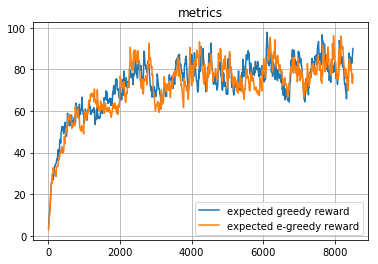

Random session examples


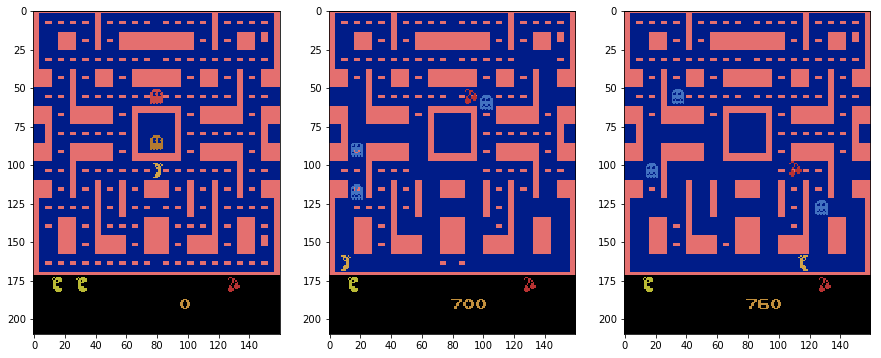

epoch 8510,loss 1223.18438, epsilon 0.05009, rewards: ( e-greedy 79.78035, greedy 100.97365) 
rec 1223.060 reg 0.124
epoch 8520,loss 2678.54691, epsilon 0.05009, rewards: ( e-greedy 84.05231, greedy 98.43878) 
rec 2678.423 reg 0.124
epoch 8530,loss 620.39448, epsilon 0.05009, rewards: ( e-greedy 83.52208, greedy 97.28241) 
rec 620.270 reg 0.124
epoch 8540,loss 618.55617, epsilon 0.05009, rewards: ( e-greedy 83.54487, greedy 92.92916) 
rec 618.432 reg 0.124
epoch 8550,loss 592.51736, epsilon 0.05009, rewards: ( e-greedy 85.62789, greedy 92.44875) 
rec 592.393 reg 0.125
epoch 8560,loss 442.88600, epsilon 0.05009, rewards: ( e-greedy 84.44010, greedy 89.01637) 
rec 442.761 reg 0.125
epoch 8570,loss 630.30238, epsilon 0.05009, rewards: ( e-greedy 79.55859, greedy 86.55224) 
rec 630.178 reg 0.125
epoch 8580,loss 411.11908, epsilon 0.05008, rewards: ( e-greedy 78.41523, greedy 94.20951) 
rec 410.994 reg 0.125
epoch 8590,loss 495.05334, epsilon 0.05008, rewards: ( e-greedy 79.51121, greedy 99

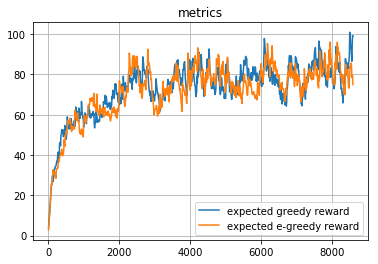

Random session examples


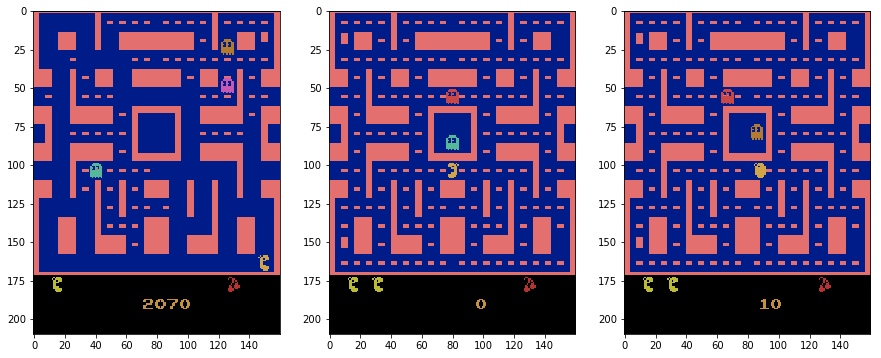

epoch 8610,loss 320.76424, epsilon 0.05008, rewards: ( e-greedy 71.31658, greedy 97.64311) 
rec 320.639 reg 0.125
epoch 8620,loss 644.32909, epsilon 0.05008, rewards: ( e-greedy 72.18492, greedy 91.81630) 
rec 644.204 reg 0.125
epoch 8630,loss 294.94753, epsilon 0.05008, rewards: ( e-greedy 70.71643, greedy 89.69717) 
rec 294.823 reg 0.125
epoch 8640,loss 260.26797, epsilon 0.05008, rewards: ( e-greedy 68.14478, greedy 88.91495) 
rec 260.143 reg 0.125
epoch 8650,loss 425.54357, epsilon 0.05008, rewards: ( e-greedy 67.83031, greedy 87.39846) 
rec 425.419 reg 0.125
epoch 8660,loss 259.72602, epsilon 0.05008, rewards: ( e-greedy 65.79728, greedy 86.72111) 
rec 259.601 reg 0.125
epoch 8670,loss 4529.38486, epsilon 0.05008, rewards: ( e-greedy 73.84255, greedy 88.48650) 
rec 4529.260 reg 0.125
epoch 8680,loss 139.27141, epsilon 0.05008, rewards: ( e-greedy 70.20829, greedy 82.38785) 
rec 139.146 reg 0.125
epoch 8690,loss 717.25374, epsilon 0.05008, rewards: ( e-greedy 70.56246, greedy 78.89

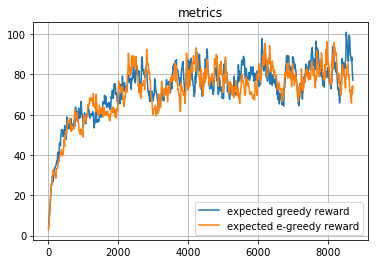

Random session examples


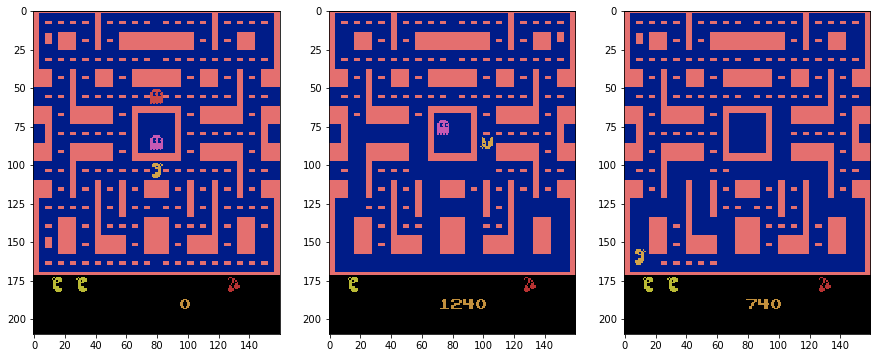

epoch 8710,loss 504.13897, epsilon 0.05007, rewards: ( e-greedy 75.82435, greedy 78.67074) 
rec 504.014 reg 0.125
epoch 8720,loss 326.18920, epsilon 0.05007, rewards: ( e-greedy 73.49191, greedy 77.42867) 
rec 326.064 reg 0.125
epoch 8730,loss 499.51935, epsilon 0.05007, rewards: ( e-greedy 70.08022, greedy 78.43580) 
rec 499.394 reg 0.125
epoch 8740,loss 180.29054, epsilon 0.05007, rewards: ( e-greedy 67.44720, greedy 73.90472) 
rec 180.165 reg 0.125
epoch 8750,loss 1886.95559, epsilon 0.05007, rewards: ( e-greedy 68.32748, greedy 73.38925) 
rec 1886.830 reg 0.125
epoch 8760,loss 246.08594, epsilon 0.05007, rewards: ( e-greedy 65.68223, greedy 69.86282) 
rec 245.960 reg 0.126
epoch 8770,loss 394.63669, epsilon 0.05007, rewards: ( e-greedy 66.61401, greedy 74.56404) 
rec 394.511 reg 0.126
epoch 8780,loss 478.68269, epsilon 0.05007, rewards: ( e-greedy 66.32761, greedy 74.79514) 
rec 478.557 reg 0.126
epoch 8790,loss 393.33765, epsilon 0.05007, rewards: ( e-greedy 63.81985, greedy 72.12

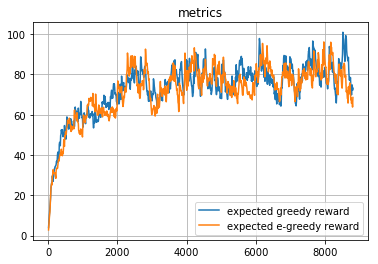

Random session examples


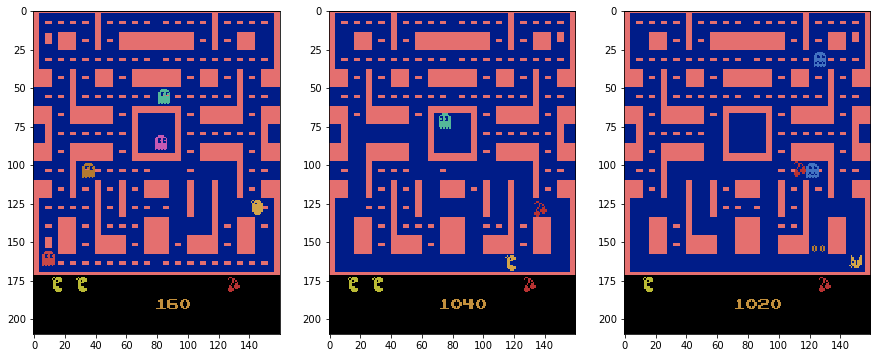

epoch 8810,loss 322.27231, epsilon 0.05007, rewards: ( e-greedy 67.39408, greedy 74.47378) 
rec 322.147 reg 0.126
epoch 8820,loss 268.86559, epsilon 0.05007, rewards: ( e-greedy 65.27967, greedy 77.15140) 
rec 268.740 reg 0.126
epoch 8830,loss 695.65061, epsilon 0.05007, rewards: ( e-greedy 66.00170, greedy 76.06126) 
rec 695.525 reg 0.126
epoch 8840,loss 306.19865, epsilon 0.05007, rewards: ( e-greedy 63.46403, greedy 74.95514) 
rec 306.073 reg 0.126
epoch 8850,loss 350.58472, epsilon 0.05006, rewards: ( e-greedy 62.30513, greedy 72.52212) 
rec 350.459 reg 0.126
epoch 8860,loss 289.91709, epsilon 0.05006, rewards: ( e-greedy 60.88712, greedy 74.64491) 
rec 289.791 reg 0.126
epoch 8870,loss 1885.08509, epsilon 0.05006, rewards: ( e-greedy 65.61090, greedy 74.43042) 
rec 1884.959 reg 0.126
epoch 8880,loss 947.42462, epsilon 0.05006, rewards: ( e-greedy 69.48731, greedy 73.36238) 
rec 947.298 reg 0.126
epoch 8890,loss 278.62417, epsilon 0.05006, rewards: ( e-greedy 67.97608, greedy 72.15

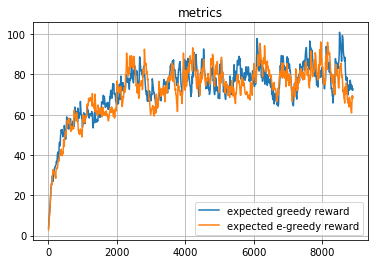

Random session examples


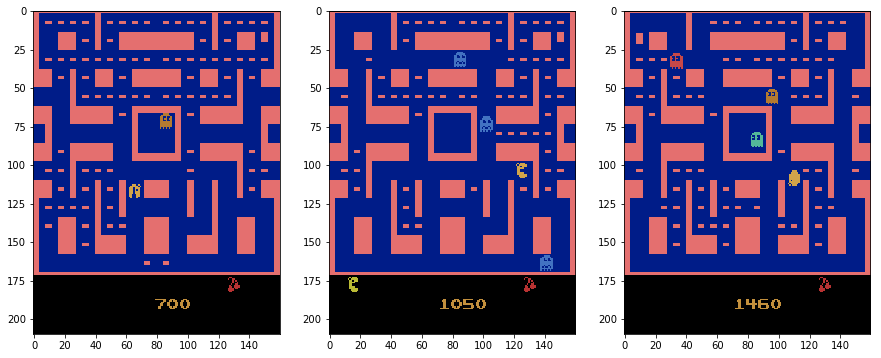

epoch 8910,loss 341.72376, epsilon 0.05006, rewards: ( e-greedy 68.77313, greedy 76.77992) 
rec 341.597 reg 0.126
epoch 8920,loss 12113.03254, epsilon 0.05006, rewards: ( e-greedy 85.45831, greedy 79.97693) 
rec 12112.906 reg 0.126
epoch 8930,loss 582.62412, epsilon 0.05006, rewards: ( e-greedy 83.41248, greedy 76.41674) 
rec 582.498 reg 0.127
epoch 8940,loss 384.47083, epsilon 0.05006, rewards: ( e-greedy 81.32123, greedy 75.08756) 
rec 384.344 reg 0.127
epoch 8950,loss 504.54037, epsilon 0.05006, rewards: ( e-greedy 77.87661, greedy 75.70381) 
rec 504.414 reg 0.127
epoch 8960,loss 360.36485, epsilon 0.05006, rewards: ( e-greedy 76.08895, greedy 77.32093) 
rec 360.238 reg 0.127
epoch 8970,loss 2737.89675, epsilon 0.05006, rewards: ( e-greedy 80.98005, greedy 80.58883) 
rec 2737.770 reg 0.127
epoch 8980,loss 1847.17006, epsilon 0.05006, rewards: ( e-greedy 88.44455, greedy 81.96745) 
rec 1847.043 reg 0.127
epoch 8990,loss 509.30408, epsilon 0.05006, rewards: ( e-greedy 86.22509, greedy

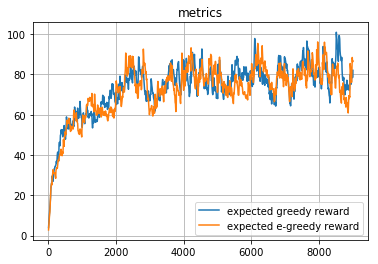

Random session examples


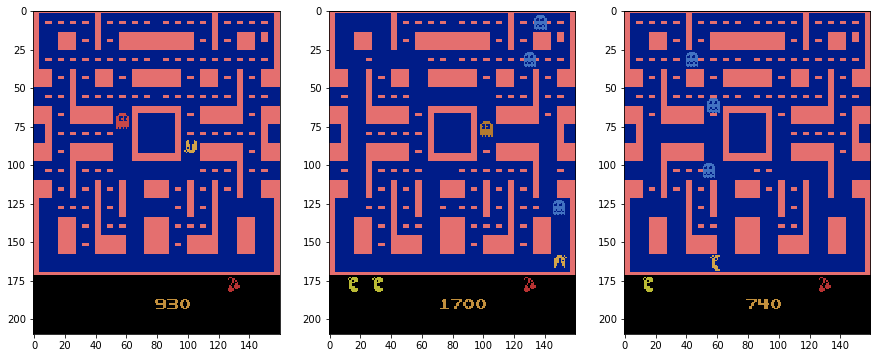

[2017-05-25 05:32:50,862] Making new env: MsPacman-v0
[2017-05-25 05:32:51,037] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 05:32:51,046] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.11.25470.video000000.mp4
[2017-05-25 05:32:53,637] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.11.25470.video000001.mp4


Episode finished after 525 timesteps with reward=190.0
Episode finished after 340 timesteps with reward=80.0
Episode finished after 389 timesteps with reward=190.0
Episode finished after 775 timesteps with reward=430.0
Episode finished after 501 timesteps with reward=200.0
Episode finished after 505 timesteps with reward=210.0
Episode finished after 658 timesteps with reward=410.0


[2017-05-25 05:33:10,036] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.11.25470.video000008.mp4


Episode finished after 692 timesteps with reward=290.0
Episode finished after 464 timesteps with reward=270.0
Episode finished after 659 timesteps with reward=270.0
Episode finished after 984 timesteps with reward=540.0
Episode finished after 768 timesteps with reward=450.0
Episode finished after 424 timesteps with reward=230.0
Episode finished after 604 timesteps with reward=180.0
Episode finished after 465 timesteps with reward=150.0
Episode finished after 585 timesteps with reward=260.0
Episode finished after 718 timesteps with reward=340.0
Episode finished after 654 timesteps with reward=430.0
Episode finished after 527 timesteps with reward=280.0


[2017-05-25 05:33:42,174] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')


Episode finished after 536 timesteps with reward=310.0
Mean 285.5, Var 12994.75
epoch 9010,loss 403.64293, epsilon 0.05005, rewards: ( e-greedy 86.06108, greedy 81.71990) 
rec 403.516 reg 0.127
epoch 9020,loss 924.77996, epsilon 0.05005, rewards: ( e-greedy 87.20497, greedy 91.54791) 
rec 924.653 reg 0.127
epoch 9030,loss 228.36652, epsilon 0.05005, rewards: ( e-greedy 82.73447, greedy 88.45562) 
rec 228.239 reg 0.127
epoch 9040,loss 1618.99349, epsilon 0.05005, rewards: ( e-greedy 84.52352, greedy 90.04755) 
rec 1618.866 reg 0.127
epoch 9050,loss 560.00276, epsilon 0.05005, rewards: ( e-greedy 84.32117, greedy 88.54280) 
rec 559.876 reg 0.127
epoch 9060,loss 2032.14187, epsilon 0.05005, rewards: ( e-greedy 84.38905, greedy 83.37602) 
rec 2032.015 reg 0.127
epoch 9070,loss 1913.76878, epsilon 0.05005, rewards: ( e-greedy 90.51265, greedy 90.97592) 
rec 1913.642 reg 0.127
epoch 9080,loss 2533.02380, epsilon 0.05005, rewards: ( e-greedy 95.71138, greedy 94.81583) 
rec 2532.897 reg 0.127


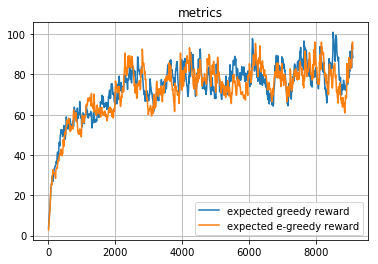

Random session examples


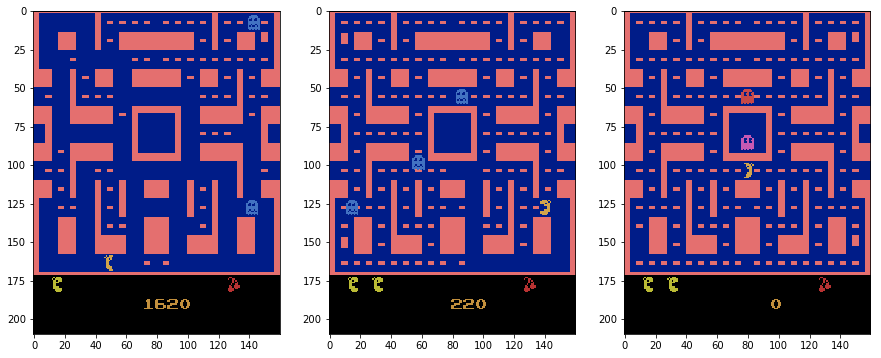

epoch 9110,loss 1967.59161, epsilon 0.05005, rewards: ( e-greedy 93.05485, greedy 87.61136) 
rec 1967.464 reg 0.128
epoch 9120,loss 493.25400, epsilon 0.05005, rewards: ( e-greedy 88.31186, greedy 87.66273) 
rec 493.126 reg 0.128
epoch 9130,loss 882.45996, epsilon 0.05005, rewards: ( e-greedy 92.04318, greedy 90.02145) 
rec 882.332 reg 0.128
epoch 9140,loss 515.24323, epsilon 0.05005, rewards: ( e-greedy 90.46386, greedy 88.26931) 
rec 515.115 reg 0.128
epoch 9150,loss 1246.78985, epsilon 0.05005, rewards: ( e-greedy 90.66747, greedy 86.56738) 
rec 1246.662 reg 0.128
epoch 9160,loss 354.73997, epsilon 0.05005, rewards: ( e-greedy 87.41323, greedy 86.03564) 
rec 354.612 reg 0.128
epoch 9170,loss 4416.83445, epsilon 0.05005, rewards: ( e-greedy 97.29690, greedy 81.80708) 
rec 4416.706 reg 0.128
epoch 9180,loss 3551.21519, epsilon 0.05005, rewards: ( e-greedy 101.94221, greedy 81.62637) 
rec 3551.087 reg 0.128
epoch 9190,loss 424.00100, epsilon 0.05005, rewards: ( e-greedy 96.74799, greed

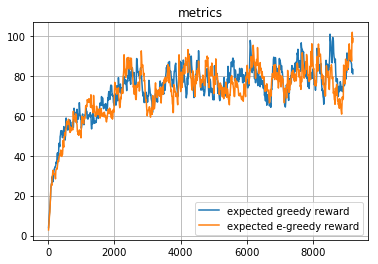

Random session examples


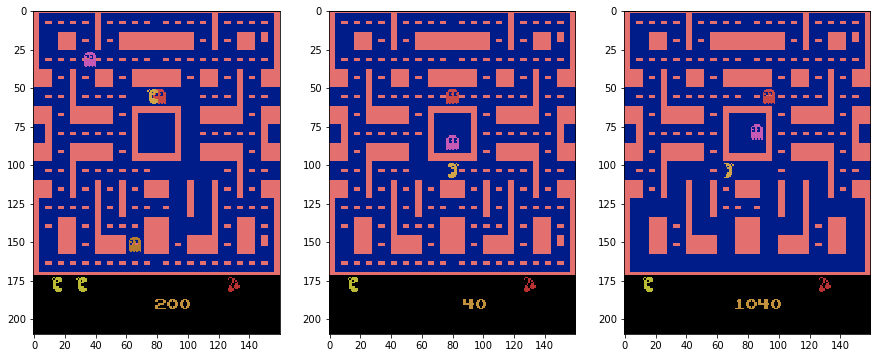

epoch 9210,loss 856.20863, epsilon 0.05005, rewards: ( e-greedy 98.00337, greedy 81.88062) 
rec 856.080 reg 0.128
epoch 9220,loss 401.17380, epsilon 0.05004, rewards: ( e-greedy 94.39054, greedy 83.81756) 
rec 401.045 reg 0.128
epoch 9230,loss 5255.46865, epsilon 0.05004, rewards: ( e-greedy 103.45148, greedy 81.68580) 
rec 5255.340 reg 0.128
epoch 9240,loss 622.00722, epsilon 0.05004, rewards: ( e-greedy 99.16883, greedy 80.57972) 
rec 621.879 reg 0.128
epoch 9250,loss 946.81924, epsilon 0.05004, rewards: ( e-greedy 98.31445, greedy 83.02175) 
rec 946.691 reg 0.128
epoch 9260,loss 418.29019, epsilon 0.05004, rewards: ( e-greedy 96.85801, greedy 86.15708) 
rec 418.162 reg 0.129
epoch 9270,loss 677.36931, epsilon 0.05004, rewards: ( e-greedy 94.54721, greedy 86.54137) 
rec 677.241 reg 0.129
epoch 9280,loss 1112.15184, epsilon 0.05004, rewards: ( e-greedy 96.09248, greedy 84.44973) 
rec 1112.023 reg 0.129
epoch 9290,loss 2283.93587, epsilon 0.05004, rewards: ( e-greedy 98.04574, greedy 8

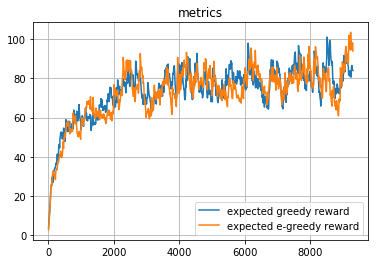

Random session examples


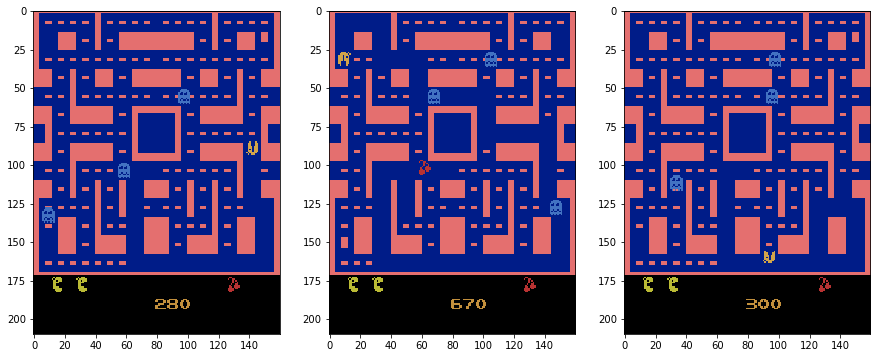

epoch 9310,loss 303.91864, epsilon 0.05004, rewards: ( e-greedy 89.10455, greedy 82.41073) 
rec 303.790 reg 0.129
epoch 9320,loss 566.37449, epsilon 0.05004, rewards: ( e-greedy 86.69409, greedy 89.73216) 
rec 566.246 reg 0.129
epoch 9330,loss 812.85704, epsilon 0.05004, rewards: ( e-greedy 86.71218, greedy 86.75894) 
rec 812.728 reg 0.129
epoch 9340,loss 362.70171, epsilon 0.05004, rewards: ( e-greedy 83.66596, greedy 84.70805) 
rec 362.573 reg 0.129
epoch 9350,loss 586.22539, epsilon 0.05004, rewards: ( e-greedy 80.92437, greedy 88.36224) 
rec 586.097 reg 0.129
epoch 9360,loss 360.56181, epsilon 0.05004, rewards: ( e-greedy 77.51943, greedy 85.77602) 
rec 360.433 reg 0.129
epoch 9370,loss 4925.64527, epsilon 0.05004, rewards: ( e-greedy 88.57999, greedy 88.82342) 
rec 4925.516 reg 0.129
epoch 9380,loss 512.53591, epsilon 0.05004, rewards: ( e-greedy 86.53449, greedy 99.06607) 
rec 512.407 reg 0.129
epoch 9390,loss 1387.18544, epsilon 0.05004, rewards: ( e-greedy 91.69354, greedy 95.0

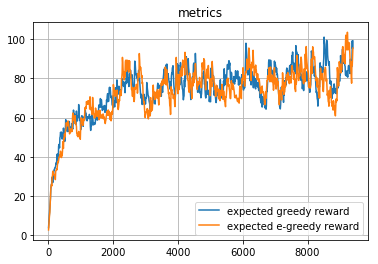

Random session examples


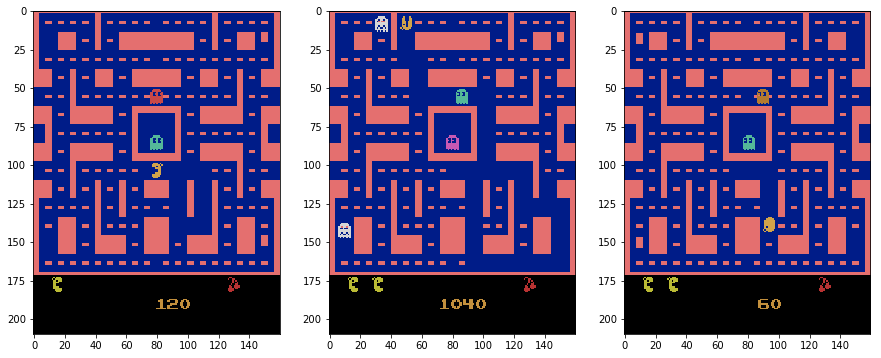

epoch 9410,loss 389.43452, epsilon 0.05004, rewards: ( e-greedy 92.73427, greedy 95.99729) 
rec 389.305 reg 0.129
epoch 9420,loss 787.04005, epsilon 0.05004, rewards: ( e-greedy 93.58584, greedy 96.64756) 
rec 786.911 reg 0.130
epoch 9430,loss 435.56409, epsilon 0.05004, rewards: ( e-greedy 93.35226, greedy 95.92031) 
rec 435.435 reg 0.129
epoch 9440,loss 623.42456, epsilon 0.05004, rewards: ( e-greedy 89.95453, greedy 95.95328) 
rec 623.295 reg 0.129
epoch 9450,loss 6232.26498, epsilon 0.05004, rewards: ( e-greedy 95.70908, greedy 92.23295) 
rec 6232.136 reg 0.129
epoch 9460,loss 540.57303, epsilon 0.05004, rewards: ( e-greedy 91.70067, greedy 96.25965) 
rec 540.443 reg 0.130
epoch 9470,loss 6546.58283, epsilon 0.05003, rewards: ( e-greedy 96.03060, greedy 92.07119) 
rec 6546.453 reg 0.130
epoch 9480,loss 838.24220, epsilon 0.05003, rewards: ( e-greedy 92.67754, greedy 93.23907) 
rec 838.112 reg 0.130
epoch 9490,loss 416.88457, epsilon 0.05003, rewards: ( e-greedy 88.53479, greedy 90.

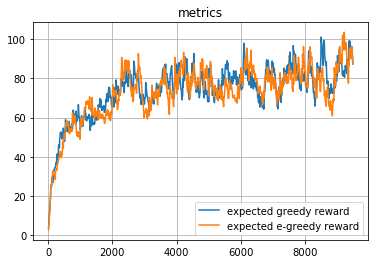

Random session examples


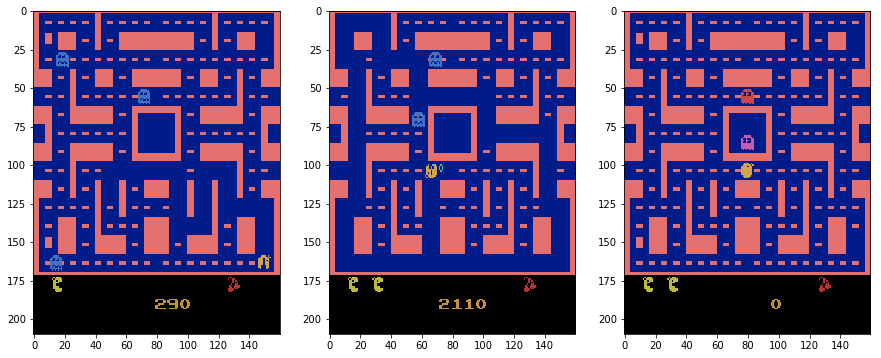

epoch 9510,loss 9925.43167, epsilon 0.05003, rewards: ( e-greedy 95.40068, greedy 92.48941) 
rec 9925.302 reg 0.130
epoch 9520,loss 1368.80854, epsilon 0.05003, rewards: ( e-greedy 96.61061, greedy 90.80297) 
rec 1368.678 reg 0.130
epoch 9530,loss 901.39265, epsilon 0.05003, rewards: ( e-greedy 97.44955, greedy 92.78517) 
rec 901.263 reg 0.130
epoch 9540,loss 5164.03460, epsilon 0.05003, rewards: ( e-greedy 103.39209, greedy 91.50665) 
rec 5163.904 reg 0.130
epoch 9550,loss 1261.43131, epsilon 0.05003, rewards: ( e-greedy 104.05289, greedy 88.35599) 
rec 1261.301 reg 0.130
epoch 9560,loss 658.00130, epsilon 0.05003, rewards: ( e-greedy 103.77260, greedy 85.14539) 
rec 657.871 reg 0.130
epoch 9570,loss 551.95382, epsilon 0.05003, rewards: ( e-greedy 101.83284, greedy 82.13085) 
rec 551.823 reg 0.130
epoch 9580,loss 2206.04751, epsilon 0.05003, rewards: ( e-greedy 106.39955, greedy 81.91776) 
rec 2205.917 reg 0.130
epoch 9590,loss 611.04544, epsilon 0.05003, rewards: ( e-greedy 103.38460

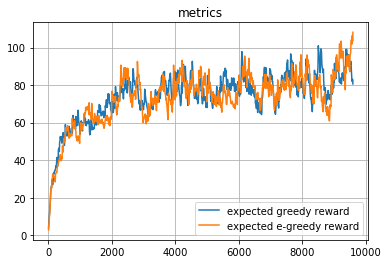

Random session examples


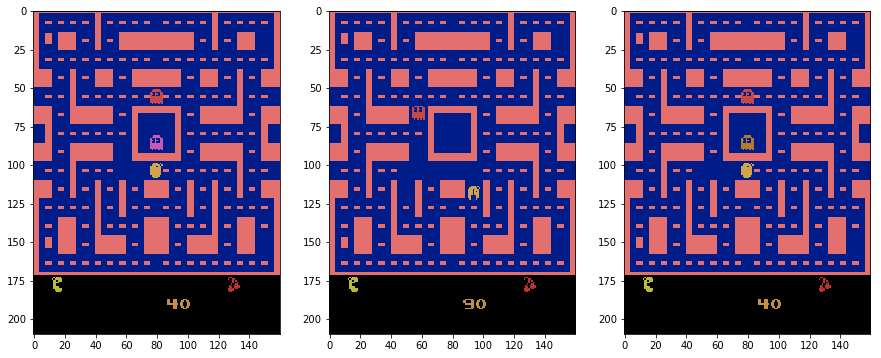

epoch 9610,loss 380.72848, epsilon 0.05003, rewards: ( e-greedy 103.47902, greedy 79.04868) 
rec 380.598 reg 0.131
epoch 9620,loss 2175.82659, epsilon 0.05003, rewards: ( e-greedy 107.31862, greedy 80.45631) 
rec 2175.696 reg 0.131
epoch 9630,loss 256.26078, epsilon 0.05003, rewards: ( e-greedy 100.64926, greedy 78.28568) 
rec 256.130 reg 0.131
epoch 9640,loss 843.41844, epsilon 0.05003, rewards: ( e-greedy 99.20933, greedy 81.01961) 
rec 843.288 reg 0.131
epoch 9650,loss 296.45427, epsilon 0.05003, rewards: ( e-greedy 93.60090, greedy 86.35515) 
rec 296.323 reg 0.131
epoch 9660,loss 683.56238, epsilon 0.05003, rewards: ( e-greedy 92.24081, greedy 88.65713) 
rec 683.431 reg 0.131
epoch 9670,loss 660.82067, epsilon 0.05003, rewards: ( e-greedy 89.01673, greedy 90.66642) 
rec 660.690 reg 0.131
epoch 9680,loss 1154.65131, epsilon 0.05003, rewards: ( e-greedy 88.11506, greedy 89.53728) 
rec 1154.520 reg 0.131
epoch 9690,loss 1039.69372, epsilon 0.05003, rewards: ( e-greedy 88.17855, greedy

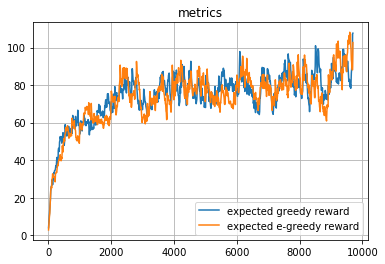

Random session examples


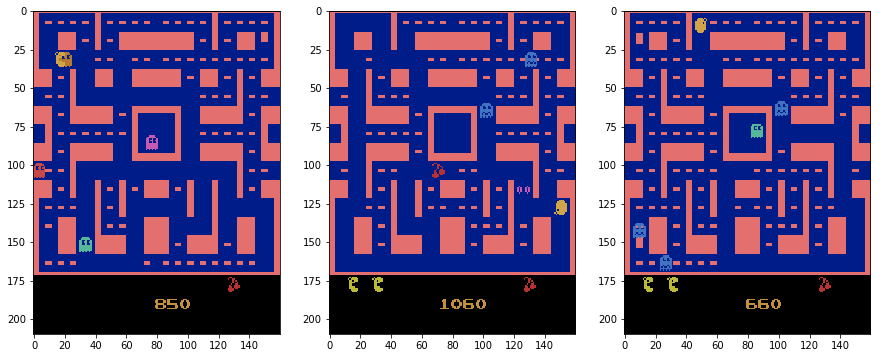

epoch 9710,loss 645.63223, epsilon 0.05003, rewards: ( e-greedy 98.84338, greedy 103.84518) 
rec 645.501 reg 0.131
epoch 9720,loss 308.80337, epsilon 0.05003, rewards: ( e-greedy 92.64654, greedy 99.58566) 
rec 308.672 reg 0.131
epoch 9730,loss 673.20692, epsilon 0.05003, rewards: ( e-greedy 90.50688, greedy 96.93959) 
rec 673.076 reg 0.131
epoch 9740,loss 532.48466, epsilon 0.05003, rewards: ( e-greedy 89.64370, greedy 99.74563) 
rec 532.354 reg 0.131
epoch 9750,loss 494.40905, epsilon 0.05003, rewards: ( e-greedy 89.05433, greedy 98.89607) 
rec 494.278 reg 0.131
epoch 9760,loss 1118.13431, epsilon 0.05003, rewards: ( e-greedy 90.39889, greedy 99.69396) 
rec 1118.003 reg 0.131
epoch 9770,loss 667.27265, epsilon 0.05003, rewards: ( e-greedy 90.10900, greedy 104.41207) 
rec 667.141 reg 0.132
epoch 9780,loss 3377.00554, epsilon 0.05003, rewards: ( e-greedy 100.47310, greedy 106.15836) 
rec 3376.874 reg 0.132
epoch 9790,loss 430.39183, epsilon 0.05003, rewards: ( e-greedy 98.67579, greedy

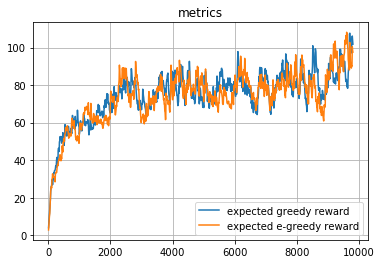

Random session examples


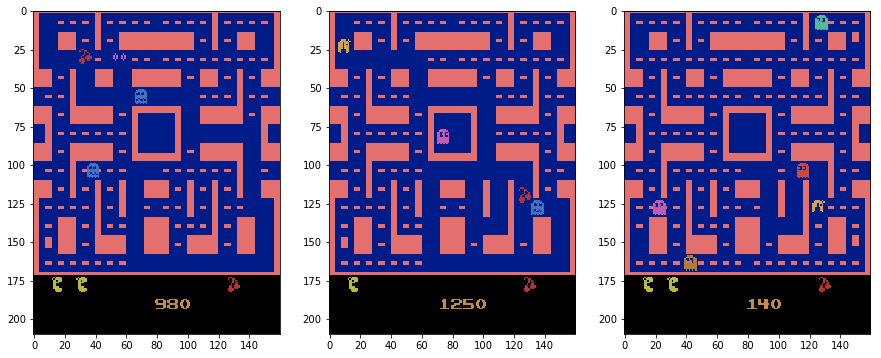

epoch 9810,loss 350.54520, epsilon 0.05002, rewards: ( e-greedy 95.17739, greedy 98.42757) 
rec 350.413 reg 0.132
epoch 9820,loss 882.87935, epsilon 0.05002, rewards: ( e-greedy 97.09715, greedy 97.70981) 
rec 882.747 reg 0.132
epoch 9830,loss 1085.40256, epsilon 0.05002, rewards: ( e-greedy 98.01244, greedy 100.75133) 
rec 1085.270 reg 0.132
epoch 9840,loss 998.94900, epsilon 0.05002, rewards: ( e-greedy 97.58619, greedy 96.17620) 
rec 998.817 reg 0.132
epoch 9850,loss 1680.54433, epsilon 0.05002, rewards: ( e-greedy 96.95257, greedy 92.68358) 
rec 1680.412 reg 0.132
epoch 9860,loss 888.04567, epsilon 0.05002, rewards: ( e-greedy 96.31982, greedy 105.47772) 
rec 887.913 reg 0.132
epoch 9870,loss 5120.99476, epsilon 0.05002, rewards: ( e-greedy 102.06284, greedy 104.05495) 
rec 5120.862 reg 0.132
epoch 9880,loss 311.86430, epsilon 0.05002, rewards: ( e-greedy 97.85655, greedy 103.27445) 
rec 311.732 reg 0.132
epoch 9890,loss 2051.44039, epsilon 0.05002, rewards: ( e-greedy 100.88340, g

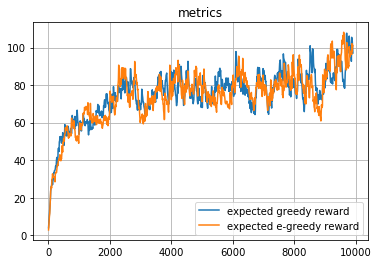

Random session examples


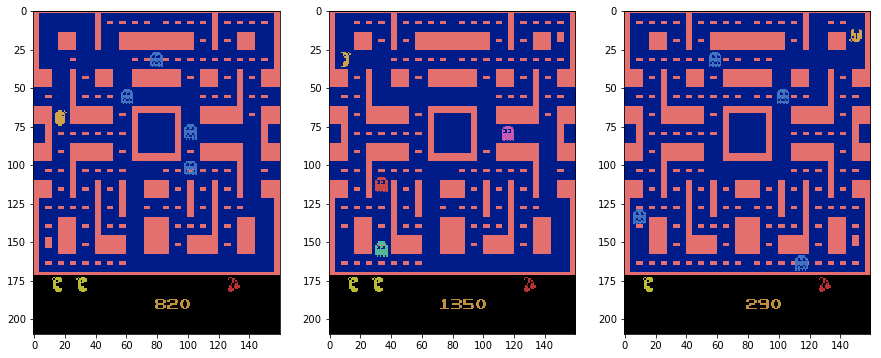

epoch 9910,loss 1044.40461, epsilon 0.05002, rewards: ( e-greedy 99.32180, greedy 95.75583) 
rec 1044.272 reg 0.133
epoch 9920,loss 887.64625, epsilon 0.05002, rewards: ( e-greedy 96.20212, greedy 94.80524) 
rec 887.514 reg 0.133
epoch 9930,loss 8592.90004, epsilon 0.05002, rewards: ( e-greedy 107.33191, greedy 91.32472) 
rec 8592.767 reg 0.133
epoch 9940,loss 1077.02220, epsilon 0.05002, rewards: ( e-greedy 107.72372, greedy 90.25475) 
rec 1076.890 reg 0.133
epoch 9950,loss 640.93999, epsilon 0.05002, rewards: ( e-greedy 103.76385, greedy 85.60427) 
rec 640.807 reg 0.133
epoch 9960,loss 1442.67842, epsilon 0.05002, rewards: ( e-greedy 104.82496, greedy 90.04385) 
rec 1442.546 reg 0.133
epoch 9970,loss 498.48249, epsilon 0.05002, rewards: ( e-greedy 99.59247, greedy 95.91446) 
rec 498.349 reg 0.133
epoch 9980,loss 403.01009, epsilon 0.05002, rewards: ( e-greedy 96.07072, greedy 94.69801) 
rec 402.877 reg 0.133
epoch 9990,loss 3578.04386, epsilon 0.05002, rewards: ( e-greedy 104.58865, 

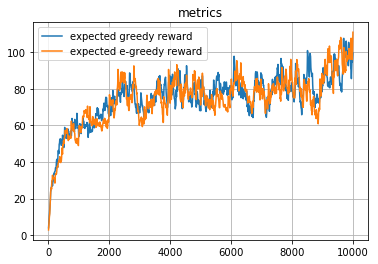

Random session examples


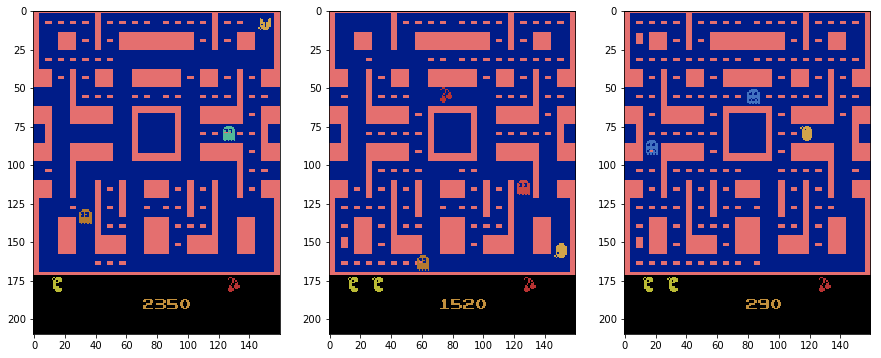

[2017-05-25 07:09:38,318] Making new env: MsPacman-v0
[2017-05-25 07:09:38,493] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 07:09:38,502] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.12.25470.video000000.mp4
[2017-05-25 07:09:42,900] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.12.25470.video000001.mp4


Episode finished after 805 timesteps with reward=620.0
Episode finished after 951 timesteps with reward=620.0
Episode finished after 898 timesteps with reward=620.0
Episode finished after 738 timesteps with reward=680.0
Episode finished after 557 timesteps with reward=260.0
Episode finished after 627 timesteps with reward=240.0
Episode finished after 820 timesteps with reward=420.0


[2017-05-25 07:10:06,259] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.12.25470.video000008.mp4


Episode finished after 614 timesteps with reward=190.0
Episode finished after 625 timesteps with reward=260.0
Episode finished after 537 timesteps with reward=150.0
Episode finished after 779 timesteps with reward=590.0
Episode finished after 840 timesteps with reward=620.0
Episode finished after 877 timesteps with reward=620.0
Episode finished after 985 timesteps with reward=1070.0
Episode finished after 648 timesteps with reward=270.0
Episode finished after 879 timesteps with reward=680.0
Episode finished after 926 timesteps with reward=1770.0
Episode finished after 607 timesteps with reward=250.0
Episode finished after 835 timesteps with reward=350.0


[2017-05-25 07:10:46,173] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')


Episode finished after 587 timesteps with reward=300.0
Mean 529.0, Var 132579.0
epoch 10010,loss 675.25432, epsilon 0.05002, rewards: ( e-greedy 109.02930, greedy 99.73485) 
rec 675.121 reg 0.133
epoch 10020,loss 432.00486, epsilon 0.05002, rewards: ( e-greedy 104.81387, greedy 102.44887) 
rec 431.872 reg 0.133
epoch 10030,loss 411.96293, epsilon 0.05002, rewards: ( e-greedy 100.95749, greedy 108.57898) 
rec 411.830 reg 0.133
epoch 10040,loss 390.31793, epsilon 0.05002, rewards: ( e-greedy 97.54924, greedy 106.84608) 
rec 390.185 reg 0.133
epoch 10050,loss 1038.83414, epsilon 0.05002, rewards: ( e-greedy 100.35681, greedy 105.09897) 
rec 1038.701 reg 0.133
epoch 10060,loss 406.84451, epsilon 0.05002, rewards: ( e-greedy 95.75863, greedy 108.15158) 
rec 406.711 reg 0.133
epoch 10070,loss 1472.33367, epsilon 0.05002, rewards: ( e-greedy 95.74527, greedy 105.71142) 
rec 1472.200 reg 0.134
epoch 10080,loss 801.63540, epsilon 0.05002, rewards: ( e-greedy 96.73324, greedy 102.01528) 
rec 801

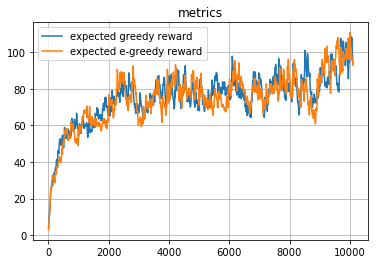

Random session examples


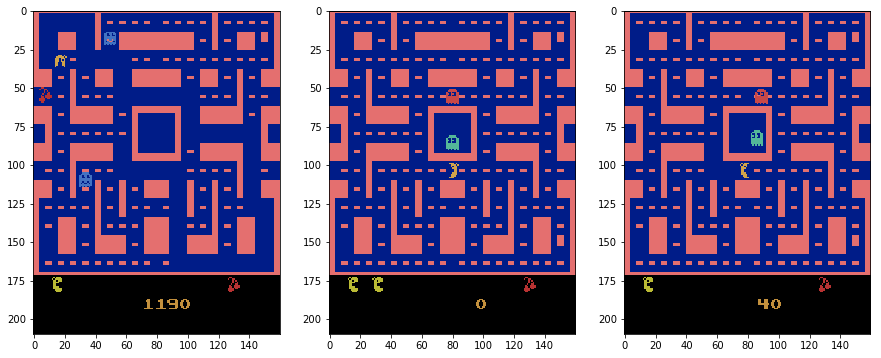

epoch 10110,loss 556.14619, epsilon 0.05002, rewards: ( e-greedy 92.62478, greedy 92.59039) 
rec 556.013 reg 0.134
epoch 10120,loss 365.68732, epsilon 0.05002, rewards: ( e-greedy 88.92481, greedy 91.64385) 
rec 365.554 reg 0.134
epoch 10130,loss 1626.56134, epsilon 0.05002, rewards: ( e-greedy 89.28232, greedy 90.10446) 
rec 1626.428 reg 0.134
epoch 10140,loss 1812.78396, epsilon 0.05002, rewards: ( e-greedy 94.66659, greedy 88.28152) 
rec 1812.650 reg 0.134
epoch 10150,loss 714.88182, epsilon 0.05002, rewards: ( e-greedy 94.82493, greedy 88.95337) 
rec 714.748 reg 0.134
epoch 10160,loss 560.20781, epsilon 0.05002, rewards: ( e-greedy 96.34244, greedy 91.55803) 
rec 560.074 reg 0.134
epoch 10170,loss 1818.34785, epsilon 0.05002, rewards: ( e-greedy 99.02070, greedy 88.58973) 
rec 1818.214 reg 0.134
epoch 10180,loss 992.62997, epsilon 0.05002, rewards: ( e-greedy 99.86863, greedy 92.91825) 
rec 992.496 reg 0.134
epoch 10190,loss 5760.04186, epsilon 0.05002, rewards: ( e-greedy 110.3817

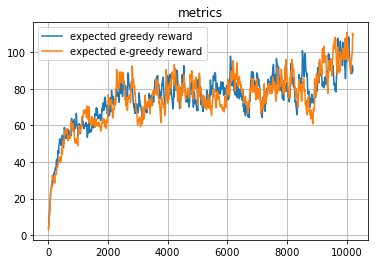

Random session examples


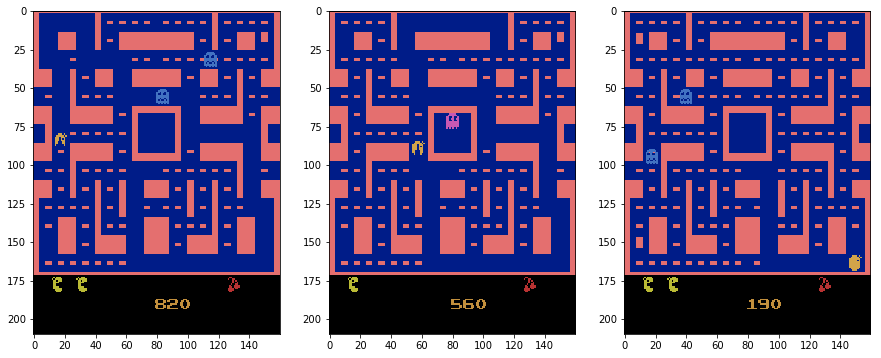

epoch 10210,loss 1966.66178, epsilon 0.05002, rewards: ( e-greedy 107.94048, greedy 103.39991) 
rec 1966.528 reg 0.134
epoch 10220,loss 1744.72910, epsilon 0.05002, rewards: ( e-greedy 106.95893, greedy 97.62242) 
rec 1744.595 reg 0.134
epoch 10230,loss 3784.65558, epsilon 0.05002, rewards: ( e-greedy 113.38804, greedy 104.86017) 
rec 3784.521 reg 0.134
epoch 10240,loss 3745.27594, epsilon 0.05002, rewards: ( e-greedy 113.42423, greedy 112.56166) 
rec 3745.142 reg 0.134
epoch 10250,loss 1603.08038, epsilon 0.05002, rewards: ( e-greedy 113.33181, greedy 116.30549) 
rec 1602.946 reg 0.135
epoch 10260,loss 1055.27008, epsilon 0.05002, rewards: ( e-greedy 110.62363, greedy 122.36244) 
rec 1055.135 reg 0.135
epoch 10270,loss 3999.47987, epsilon 0.05002, rewards: ( e-greedy 122.81127, greedy 123.56370) 
rec 3999.345 reg 0.135
epoch 10280,loss 618.22660, epsilon 0.05002, rewards: ( e-greedy 117.71764, greedy 118.89483) 
rec 618.092 reg 0.135
epoch 10290,loss 6099.97314, epsilon 0.05002, rewar

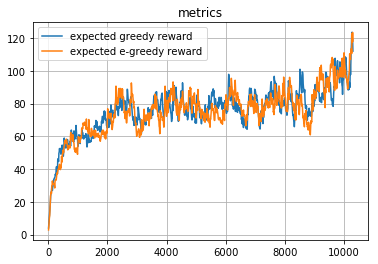

Random session examples


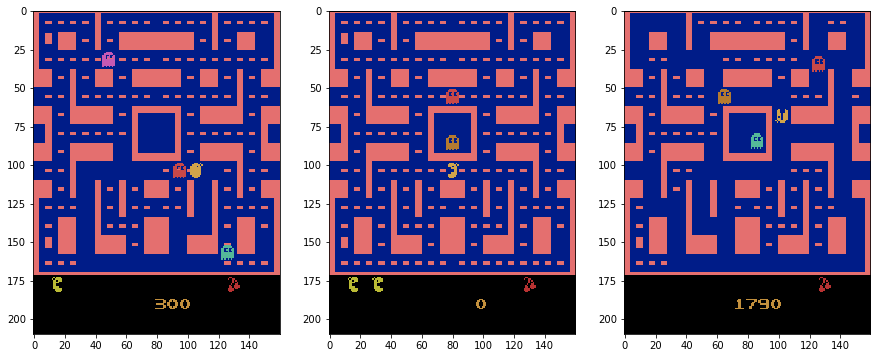

epoch 10310,loss 1006.08839, epsilon 0.05001, rewards: ( e-greedy 118.40991, greedy 111.32120) 
rec 1005.953 reg 0.135
epoch 10320,loss 1349.89926, epsilon 0.05001, rewards: ( e-greedy 118.31892, greedy 111.00158) 
rec 1349.764 reg 0.135
epoch 10330,loss 1211.14972, epsilon 0.05001, rewards: ( e-greedy 114.11203, greedy 115.08893) 
rec 1211.015 reg 0.135
epoch 10340,loss 1837.46495, epsilon 0.05001, rewards: ( e-greedy 122.26332, greedy 116.14253) 
rec 1837.330 reg 0.135
epoch 10350,loss 928.76642, epsilon 0.05001, rewards: ( e-greedy 120.91199, greedy 113.27828) 
rec 928.631 reg 0.135
epoch 10360,loss 515.18520, epsilon 0.05001, rewards: ( e-greedy 115.69579, greedy 112.13795) 
rec 515.050 reg 0.135
epoch 10370,loss 617.69864, epsilon 0.05001, rewards: ( e-greedy 111.18871, greedy 109.54916) 
rec 617.564 reg 0.135
epoch 10380,loss 5159.39619, epsilon 0.05001, rewards: ( e-greedy 114.25734, greedy 105.03174) 
rec 5159.261 reg 0.135
epoch 10390,loss 1163.24592, epsilon 0.05001, rewards:

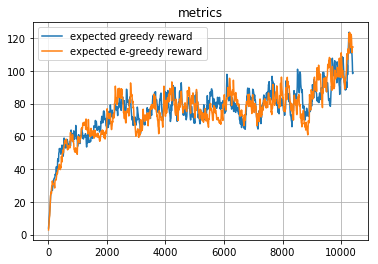

Random session examples


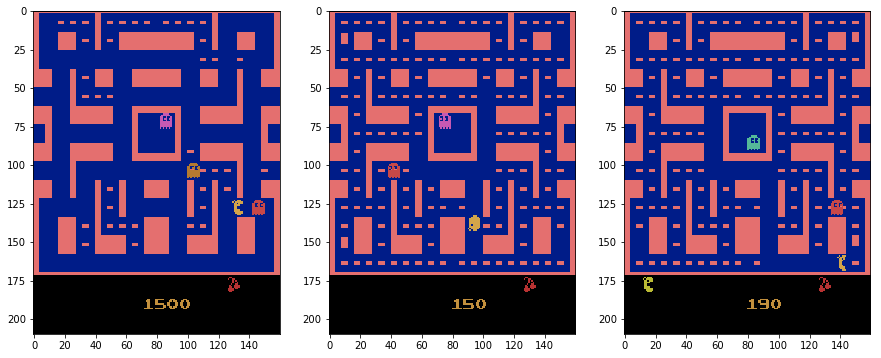

epoch 10410,loss 584.03146, epsilon 0.05001, rewards: ( e-greedy 111.59923, greedy 99.33064) 
rec 583.896 reg 0.135
epoch 10420,loss 907.13584, epsilon 0.05001, rewards: ( e-greedy 111.93930, greedy 97.89758) 
rec 907.001 reg 0.135
epoch 10430,loss 624.12169, epsilon 0.05001, rewards: ( e-greedy 106.99537, greedy 100.10782) 
rec 623.986 reg 0.135
epoch 10440,loss 648.44422, epsilon 0.05001, rewards: ( e-greedy 102.92084, greedy 105.47204) 
rec 648.309 reg 0.136
epoch 10450,loss 788.59991, epsilon 0.05001, rewards: ( e-greedy 101.06625, greedy 101.17483) 
rec 788.464 reg 0.136
epoch 10460,loss 690.75463, epsilon 0.05001, rewards: ( e-greedy 98.70963, greedy 107.55735) 
rec 690.619 reg 0.136
epoch 10470,loss 2119.58923, epsilon 0.05001, rewards: ( e-greedy 99.83866, greedy 102.80161) 
rec 2119.454 reg 0.136
epoch 10480,loss 1033.20259, epsilon 0.05001, rewards: ( e-greedy 100.79230, greedy 104.89645) 
rec 1033.067 reg 0.136
epoch 10490,loss 975.48609, epsilon 0.05001, rewards: ( e-greedy

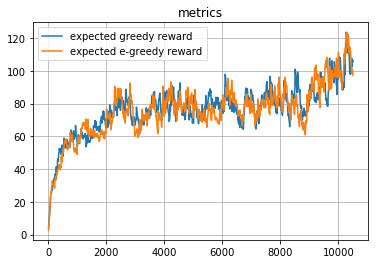

Random session examples


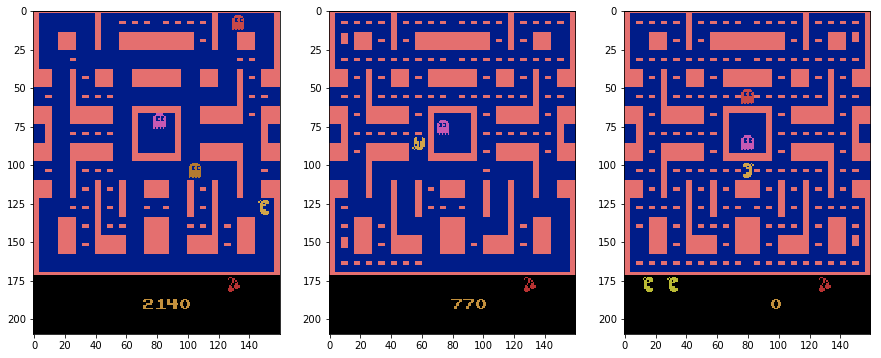

epoch 10510,loss 420.60619, epsilon 0.05001, rewards: ( e-greedy 93.65884, greedy 102.98451) 
rec 420.470 reg 0.136
epoch 10520,loss 680.26315, epsilon 0.05001, rewards: ( e-greedy 93.85545, greedy 103.18606) 
rec 680.127 reg 0.136
epoch 10530,loss 2507.35728, epsilon 0.05001, rewards: ( e-greedy 103.03241, greedy 102.42996) 
rec 2507.221 reg 0.136
epoch 10540,loss 508.82682, epsilon 0.05001, rewards: ( e-greedy 99.35417, greedy 99.37446) 
rec 508.691 reg 0.136
epoch 10550,loss 412.20978, epsilon 0.05001, rewards: ( e-greedy 96.48125, greedy 96.18701) 
rec 412.073 reg 0.136
epoch 10560,loss 532.44480, epsilon 0.05001, rewards: ( e-greedy 97.39562, greedy 99.50581) 
rec 532.308 reg 0.136
epoch 10570,loss 762.71823, epsilon 0.05001, rewards: ( e-greedy 94.15606, greedy 93.80523) 
rec 762.582 reg 0.137
epoch 10580,loss 1329.12708, epsilon 0.05001, rewards: ( e-greedy 97.42796, greedy 93.23721) 
rec 1328.991 reg 0.137
epoch 10590,loss 551.91585, epsilon 0.05001, rewards: ( e-greedy 95.0601

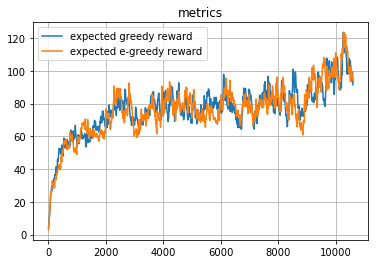

Random session examples


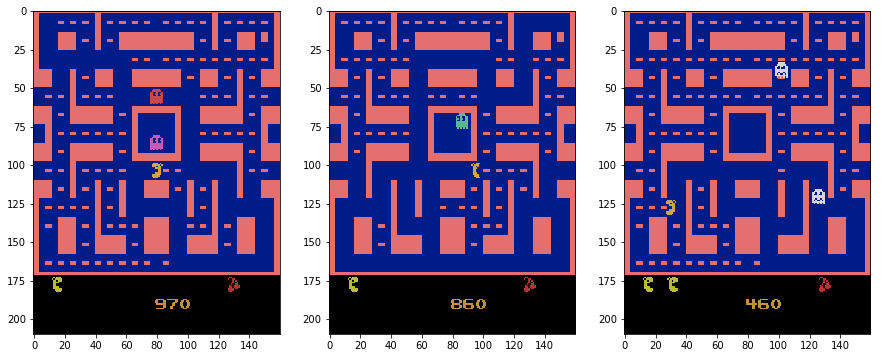

epoch 10610,loss 10215.46848, epsilon 0.05001, rewards: ( e-greedy 107.76123, greedy 93.50118) 
rec 10215.332 reg 0.137
epoch 10620,loss 744.48160, epsilon 0.05001, rewards: ( e-greedy 100.98511, greedy 94.27606) 
rec 744.345 reg 0.137
epoch 10630,loss 868.68894, epsilon 0.05001, rewards: ( e-greedy 97.94910, greedy 90.97345) 
rec 868.552 reg 0.137
epoch 10640,loss 1516.49220, epsilon 0.05001, rewards: ( e-greedy 103.52919, greedy 90.31361) 
rec 1516.356 reg 0.137
epoch 10650,loss 890.26352, epsilon 0.05001, rewards: ( e-greedy 98.73877, greedy 88.09475) 
rec 890.127 reg 0.137
epoch 10660,loss 649.39226, epsilon 0.05001, rewards: ( e-greedy 95.98989, greedy 87.53527) 
rec 649.255 reg 0.137
epoch 10670,loss 4460.95018, epsilon 0.05001, rewards: ( e-greedy 102.76590, greedy 83.84424) 
rec 4460.813 reg 0.137
epoch 10680,loss 371.72364, epsilon 0.05001, rewards: ( e-greedy 98.92681, greedy 85.64732) 
rec 371.587 reg 0.137
epoch 10690,loss 8749.90764, epsilon 0.05001, rewards: ( e-greedy 10

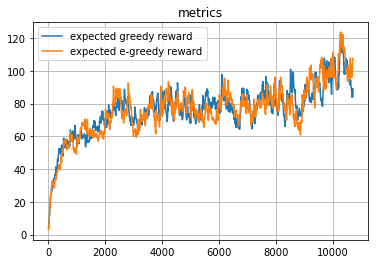

Random session examples


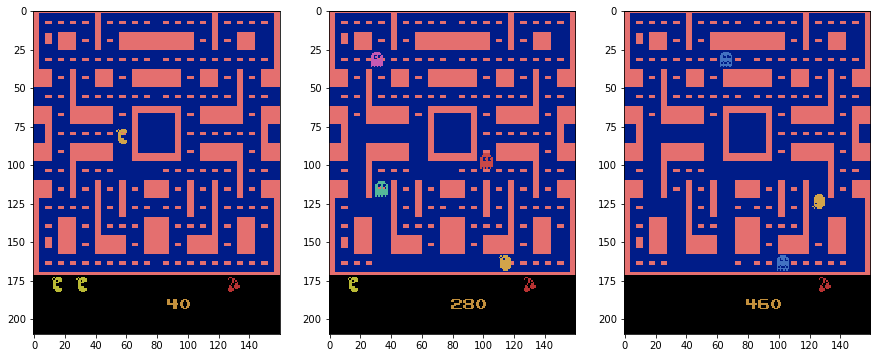

epoch 10710,loss 6525.76574, epsilon 0.05001, rewards: ( e-greedy 111.29015, greedy 85.22065) 
rec 6525.629 reg 0.137
epoch 10720,loss 489.09020, epsilon 0.05001, rewards: ( e-greedy 109.97363, greedy 88.32358) 
rec 488.953 reg 0.137
epoch 10730,loss 4054.86567, epsilon 0.05001, rewards: ( e-greedy 111.72627, greedy 91.24122) 
rec 4054.728 reg 0.137
epoch 10740,loss 452.54481, epsilon 0.05001, rewards: ( e-greedy 105.86614, greedy 89.92960) 
rec 452.408 reg 0.137
epoch 10750,loss 836.70705, epsilon 0.05001, rewards: ( e-greedy 106.46703, greedy 92.62414) 
rec 836.570 reg 0.137
epoch 10760,loss 950.42589, epsilon 0.05001, rewards: ( e-greedy 104.88282, greedy 94.86173) 
rec 950.289 reg 0.137
epoch 10770,loss 330.08387, epsilon 0.05001, rewards: ( e-greedy 97.20704, greedy 89.43805) 
rec 329.946 reg 0.137
epoch 10780,loss 2809.50289, epsilon 0.05001, rewards: ( e-greedy 96.48634, greedy 93.30675) 
rec 2809.365 reg 0.137
epoch 10790,loss 968.28139, epsilon 0.05001, rewards: ( e-greedy 98.

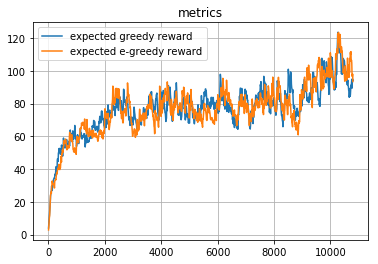

Random session examples


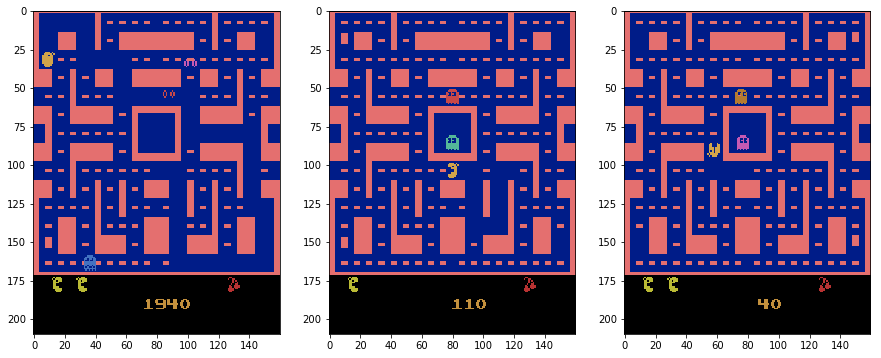

epoch 10810,loss 581.21317, epsilon 0.05001, rewards: ( e-greedy 92.93792, greedy 92.69874) 
rec 581.076 reg 0.137
epoch 10820,loss 777.26550, epsilon 0.05001, rewards: ( e-greedy 94.20662, greedy 89.42887) 
rec 777.128 reg 0.137
epoch 10830,loss 401.57220, epsilon 0.05001, rewards: ( e-greedy 92.34846, greedy 90.17348) 
rec 401.435 reg 0.137
epoch 10840,loss 419.43728, epsilon 0.05001, rewards: ( e-greedy 90.05112, greedy 89.53113) 
rec 419.300 reg 0.137
epoch 10850,loss 1346.40200, epsilon 0.05001, rewards: ( e-greedy 93.67100, greedy 93.32802) 
rec 1346.265 reg 0.137
epoch 10860,loss 5458.84494, epsilon 0.05001, rewards: ( e-greedy 100.55390, greedy 93.80772) 
rec 5458.707 reg 0.138
epoch 10870,loss 313.25771, epsilon 0.05001, rewards: ( e-greedy 94.87351, greedy 90.55195) 
rec 313.120 reg 0.138
epoch 10880,loss 1579.00333, epsilon 0.05001, rewards: ( e-greedy 93.26116, greedy 87.37175) 
rec 1578.866 reg 0.138
epoch 10890,loss 911.13327, epsilon 0.05001, rewards: ( e-greedy 94.93505

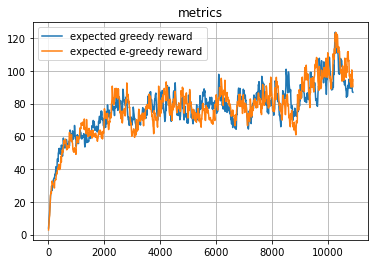

Random session examples


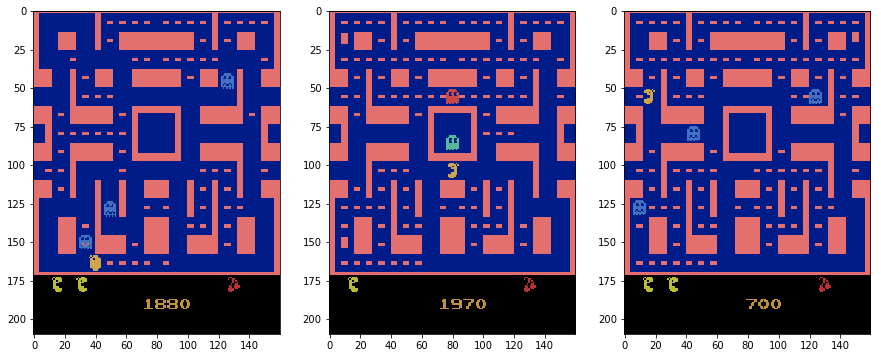

epoch 10910,loss 1234.83975, epsilon 0.05001, rewards: ( e-greedy 94.28489, greedy 91.12713) 
rec 1234.702 reg 0.138
epoch 10920,loss 1640.10240, epsilon 0.05001, rewards: ( e-greedy 97.98140, greedy 94.13942) 
rec 1639.965 reg 0.138
epoch 10930,loss 408.55762, epsilon 0.05001, rewards: ( e-greedy 93.37076, greedy 96.72548) 
rec 408.420 reg 0.138
epoch 10940,loss 469.85373, epsilon 0.05001, rewards: ( e-greedy 94.34618, greedy 96.17793) 
rec 469.716 reg 0.138
epoch 10950,loss 692.31172, epsilon 0.05001, rewards: ( e-greedy 92.03656, greedy 94.12264) 
rec 692.174 reg 0.138
epoch 10960,loss 3247.47567, epsilon 0.05001, rewards: ( e-greedy 95.64541, greedy 94.27287) 
rec 3247.338 reg 0.138
epoch 10970,loss 1322.37462, epsilon 0.05001, rewards: ( e-greedy 97.39337, greedy 102.90809) 
rec 1322.237 reg 0.138
epoch 10980,loss 355.31163, epsilon 0.05001, rewards: ( e-greedy 91.84153, greedy 99.42978) 
rec 355.174 reg 0.138
epoch 10990,loss 1799.61333, epsilon 0.05001, rewards: ( e-greedy 95.96

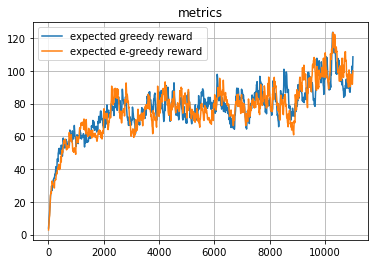

Random session examples


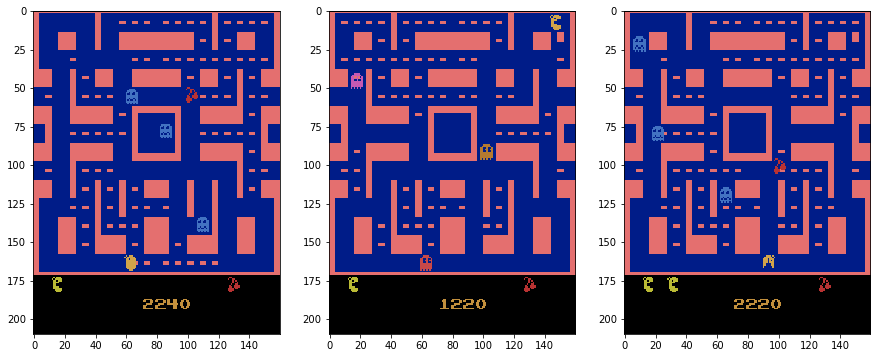

[2017-05-25 08:47:47,098] Making new env: MsPacman-v0
[2017-05-25 08:47:47,272] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 08:47:47,281] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.13.25470.video000000.mp4
[2017-05-25 08:47:52,979] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.13.25470.video000001.mp4


Episode finished after 1199 timesteps with reward=450.0
Episode finished after 865 timesteps with reward=450.0
Episode finished after 968 timesteps with reward=440.0
Episode finished after 947 timesteps with reward=240.0
Episode finished after 970 timesteps with reward=840.0
Episode finished after 623 timesteps with reward=70.0
Episode finished after 1117 timesteps with reward=440.0


[2017-05-25 08:48:23,278] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.13.25470.video000008.mp4


Episode finished after 1094 timesteps with reward=840.0
Episode finished after 549 timesteps with reward=90.0
Episode finished after 903 timesteps with reward=450.0
Episode finished after 803 timesteps with reward=240.0
Episode finished after 894 timesteps with reward=440.0
Episode finished after 961 timesteps with reward=850.0
Episode finished after 824 timesteps with reward=490.0
Episode finished after 1021 timesteps with reward=450.0
Episode finished after 609 timesteps with reward=120.0
Episode finished after 944 timesteps with reward=440.0
Episode finished after 901 timesteps with reward=440.0
Episode finished after 595 timesteps with reward=140.0


[2017-05-25 08:49:05,976] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')


Episode finished after 950 timesteps with reward=500.0
Mean 421.0, Var 50959.0
epoch 11010,loss 671.69736, epsilon 0.05001, rewards: ( e-greedy 98.37935, greedy 105.08181) 
rec 671.559 reg 0.138
epoch 11020,loss 3987.73594, epsilon 0.05001, rewards: ( e-greedy 104.72892, greedy 102.51113) 
rec 3987.598 reg 0.138
epoch 11030,loss 455.33981, epsilon 0.05001, rewards: ( e-greedy 99.31852, greedy 99.94751) 
rec 455.201 reg 0.138
epoch 11040,loss 663.67532, epsilon 0.05001, rewards: ( e-greedy 101.26167, greedy 103.64026) 
rec 663.537 reg 0.138
epoch 11050,loss 332.38055, epsilon 0.05001, rewards: ( e-greedy 97.26050, greedy 101.40124) 
rec 332.242 reg 0.138
epoch 11060,loss 424.71994, epsilon 0.05001, rewards: ( e-greedy 92.97195, greedy 97.26111) 
rec 424.581 reg 0.138
epoch 11070,loss 1988.50037, epsilon 0.05001, rewards: ( e-greedy 94.73726, greedy 93.59750) 
rec 1988.362 reg 0.139
epoch 11080,loss 1523.06763, epsilon 0.05001, rewards: ( e-greedy 100.01353, greedy 97.73775) 
rec 1522.92

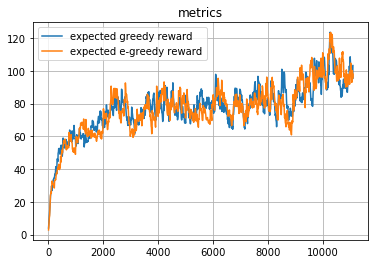

Random session examples


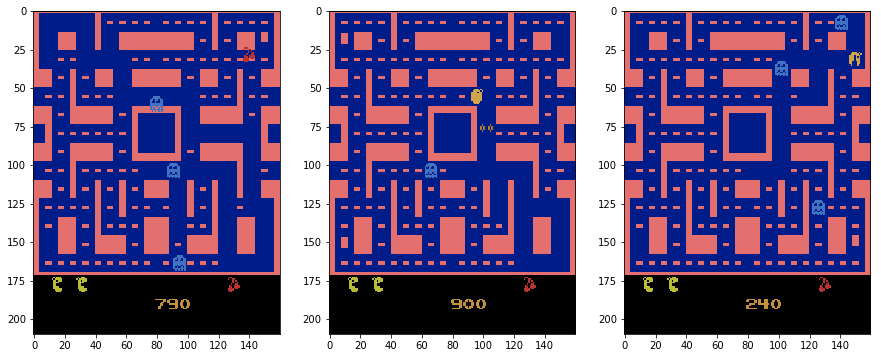

epoch 11110,loss 1893.92315, epsilon 0.05001, rewards: ( e-greedy 98.49424, greedy 97.06645) 
rec 1893.785 reg 0.139
epoch 11120,loss 772.57025, epsilon 0.05001, rewards: ( e-greedy 97.83232, greedy 104.42230) 
rec 772.432 reg 0.139
epoch 11130,loss 1663.60558, epsilon 0.05001, rewards: ( e-greedy 97.42408, greedy 99.79257) 
rec 1663.467 reg 0.139
epoch 11140,loss 4485.88272, epsilon 0.05001, rewards: ( e-greedy 107.68168, greedy 100.25081) 
rec 4485.744 reg 0.139
epoch 11150,loss 1375.33340, epsilon 0.05001, rewards: ( e-greedy 105.41351, greedy 100.47573) 
rec 1375.195 reg 0.139
epoch 11160,loss 542.86975, epsilon 0.05001, rewards: ( e-greedy 101.74716, greedy 100.42816) 
rec 542.731 reg 0.139
epoch 11170,loss 458.61596, epsilon 0.05001, rewards: ( e-greedy 100.32244, greedy 100.94784) 
rec 458.477 reg 0.139
epoch 11180,loss 1293.95039, epsilon 0.05001, rewards: ( e-greedy 101.10270, greedy 101.04056) 
rec 1293.812 reg 0.139
epoch 11190,loss 807.44958, epsilon 0.05001, rewards: ( e-g

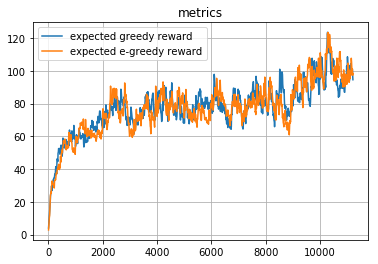

Random session examples


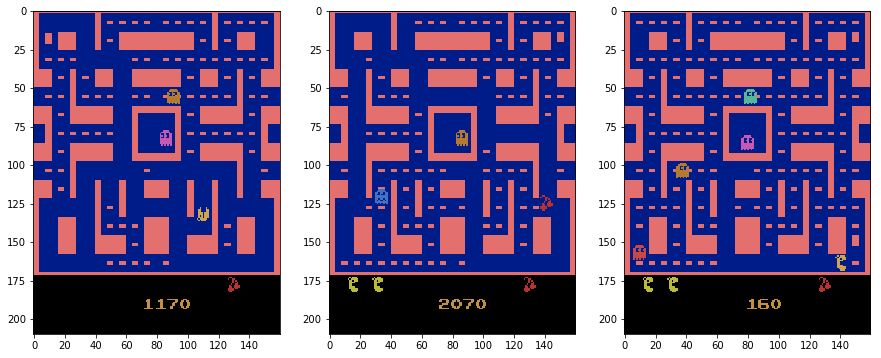

epoch 11210,loss 6891.19744, epsilon 0.05001, rewards: ( e-greedy 105.99199, greedy 95.35544) 
rec 6891.058 reg 0.139
epoch 11220,loss 1210.41734, epsilon 0.05001, rewards: ( e-greedy 103.89279, greedy 91.38240) 
rec 1210.278 reg 0.139
epoch 11230,loss 2102.87439, epsilon 0.05001, rewards: ( e-greedy 103.69101, greedy 93.43166) 
rec 2102.735 reg 0.139
epoch 11240,loss 820.18082, epsilon 0.05001, rewards: ( e-greedy 102.88441, greedy 104.46349) 
rec 820.041 reg 0.139
epoch 11250,loss 595.92653, epsilon 0.05001, rewards: ( e-greedy 98.72097, greedy 100.39214) 
rec 595.787 reg 0.139
epoch 11260,loss 423.09426, epsilon 0.05001, rewards: ( e-greedy 95.59887, greedy 101.41543) 
rec 422.955 reg 0.139
epoch 11270,loss 2955.62961, epsilon 0.05001, rewards: ( e-greedy 106.28899, greedy 102.46139) 
rec 2955.490 reg 0.140
epoch 11280,loss 580.06543, epsilon 0.05001, rewards: ( e-greedy 103.91009, greedy 105.27775) 
rec 579.926 reg 0.140
epoch 11290,loss 706.78370, epsilon 0.05001, rewards: ( e-gre

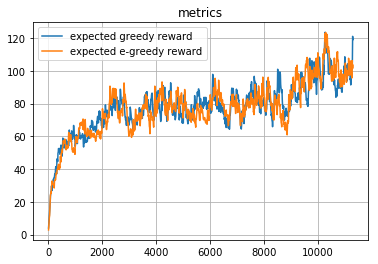

Random session examples


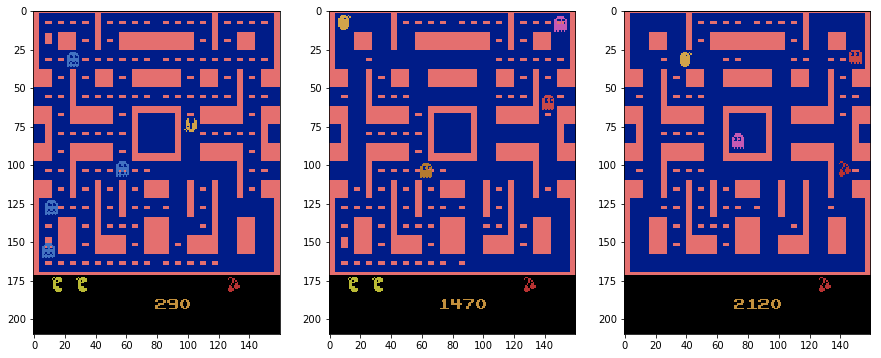

epoch 11310,loss 875.91888, epsilon 0.05001, rewards: ( e-greedy 101.40483, greedy 122.61060) 
rec 875.779 reg 0.140
epoch 11320,loss 856.68988, epsilon 0.05001, rewards: ( e-greedy 99.07685, greedy 120.59954) 
rec 856.550 reg 0.140
epoch 11330,loss 369.75878, epsilon 0.05001, rewards: ( e-greedy 95.48166, greedy 122.72709) 
rec 369.619 reg 0.140
epoch 11340,loss 467.19583, epsilon 0.05001, rewards: ( e-greedy 92.30850, greedy 121.64188) 
rec 467.056 reg 0.140
epoch 11350,loss 9178.46020, epsilon 0.05001, rewards: ( e-greedy 99.64015, greedy 119.10269) 
rec 9178.320 reg 0.140
epoch 11360,loss 656.17667, epsilon 0.05001, rewards: ( e-greedy 97.92613, greedy 121.37992) 
rec 656.036 reg 0.140
epoch 11370,loss 1191.59098, epsilon 0.05001, rewards: ( e-greedy 100.00852, greedy 114.92943) 
rec 1191.451 reg 0.140
epoch 11380,loss 346.73543, epsilon 0.05001, rewards: ( e-greedy 94.88267, greedy 119.18649) 
rec 346.595 reg 0.140
epoch 11390,loss 975.48187, epsilon 0.05001, rewards: ( e-greedy 9

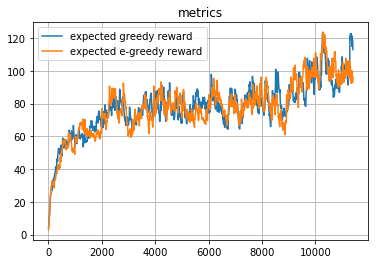

Random session examples


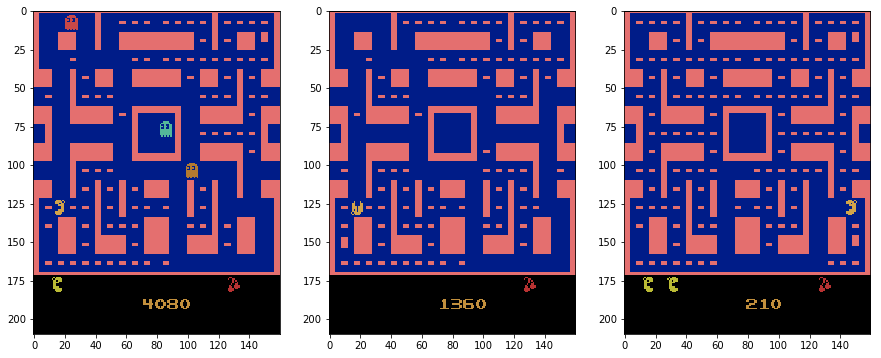

epoch 11410,loss 4889.99397, epsilon 0.05000, rewards: ( e-greedy 100.32446, greedy 109.51070) 
rec 4889.853 reg 0.141
epoch 11420,loss 1722.50336, epsilon 0.05000, rewards: ( e-greedy 98.72952, greedy 103.80963) 
rec 1722.363 reg 0.141
epoch 11430,loss 686.20999, epsilon 0.05000, rewards: ( e-greedy 96.41907, greedy 103.11617) 
rec 686.069 reg 0.141
epoch 11440,loss 519.95289, epsilon 0.05000, rewards: ( e-greedy 96.96466, greedy 105.49205) 
rec 519.812 reg 0.141
epoch 11450,loss 647.57288, epsilon 0.05000, rewards: ( e-greedy 93.39319, greedy 100.88034) 
rec 647.432 reg 0.141
epoch 11460,loss 1100.91922, epsilon 0.05000, rewards: ( e-greedy 94.86637, greedy 101.79231) 
rec 1100.778 reg 0.141
epoch 11470,loss 16585.78472, epsilon 0.05000, rewards: ( e-greedy 109.75474, greedy 100.67558) 
rec 16585.644 reg 0.141
epoch 11480,loss 11923.61528, epsilon 0.05000, rewards: ( e-greedy 123.40426, greedy 97.79552) 
rec 11923.474 reg 0.141
epoch 11490,loss 435.19655, epsilon 0.05000, rewards: ( 

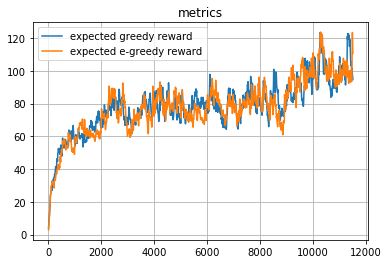

Random session examples


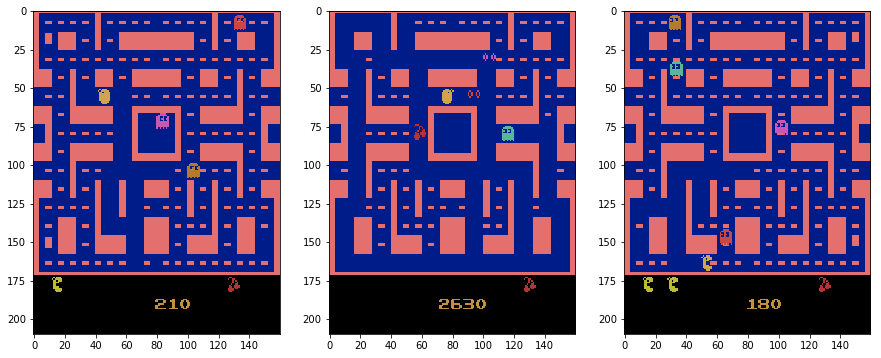

epoch 11510,loss 580.05570, epsilon 0.05000, rewards: ( e-greedy 105.62608, greedy 92.59544) 
rec 579.915 reg 0.141
epoch 11520,loss 278.93688, epsilon 0.05000, rewards: ( e-greedy 99.68847, greedy 92.02339) 
rec 278.796 reg 0.141
epoch 11530,loss 805.88758, epsilon 0.05000, rewards: ( e-greedy 98.53213, greedy 93.94605) 
rec 805.747 reg 0.141
epoch 11540,loss 810.18216, epsilon 0.05000, rewards: ( e-greedy 97.99141, greedy 94.73895) 
rec 810.041 reg 0.141
epoch 11550,loss 278.40563, epsilon 0.05000, rewards: ( e-greedy 92.44227, greedy 94.95255) 
rec 278.265 reg 0.141
epoch 11560,loss 571.79281, epsilon 0.05000, rewards: ( e-greedy 93.82305, greedy 101.64480) 
rec 571.652 reg 0.141
epoch 11570,loss 1832.71589, epsilon 0.05000, rewards: ( e-greedy 97.50324, greedy 99.85532) 
rec 1832.575 reg 0.141
epoch 11580,loss 2798.30129, epsilon 0.05000, rewards: ( e-greedy 103.50292, greedy 100.24479) 
rec 2798.160 reg 0.141
epoch 11590,loss 970.91165, epsilon 0.05000, rewards: ( e-greedy 103.652

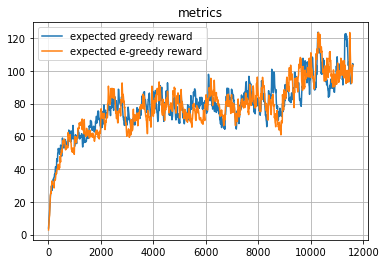

Random session examples


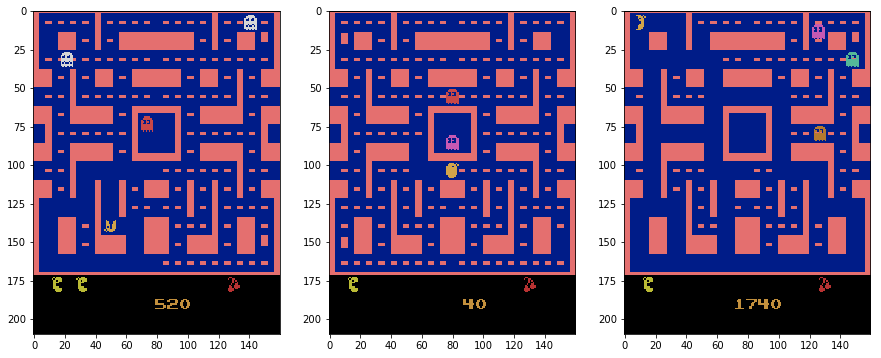

epoch 11610,loss 1421.21401, epsilon 0.05000, rewards: ( e-greedy 102.86488, greedy 103.33282) 
rec 1421.073 reg 0.141
epoch 11620,loss 310.64704, epsilon 0.05000, rewards: ( e-greedy 98.70339, greedy 105.18704) 
rec 310.506 reg 0.141
epoch 11630,loss 620.41809, epsilon 0.05000, rewards: ( e-greedy 95.02055, greedy 101.54334) 
rec 620.277 reg 0.141
epoch 11640,loss 278.31742, epsilon 0.05000, rewards: ( e-greedy 89.08099, greedy 99.82650) 
rec 278.176 reg 0.141
epoch 11650,loss 375.70359, epsilon 0.05000, rewards: ( e-greedy 85.42290, greedy 96.46885) 
rec 375.562 reg 0.141
epoch 11660,loss 348.52341, epsilon 0.05000, rewards: ( e-greedy 82.44311, greedy 90.50947) 
rec 348.382 reg 0.141
epoch 11670,loss 478.46747, epsilon 0.05000, rewards: ( e-greedy 83.57380, greedy 91.08352) 
rec 478.326 reg 0.141
epoch 11680,loss 4494.92254, epsilon 0.05000, rewards: ( e-greedy 86.02892, greedy 89.28767) 
rec 4494.781 reg 0.141
epoch 11690,loss 912.44549, epsilon 0.05000, rewards: ( e-greedy 85.6760

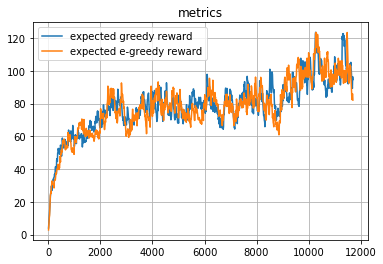

Random session examples


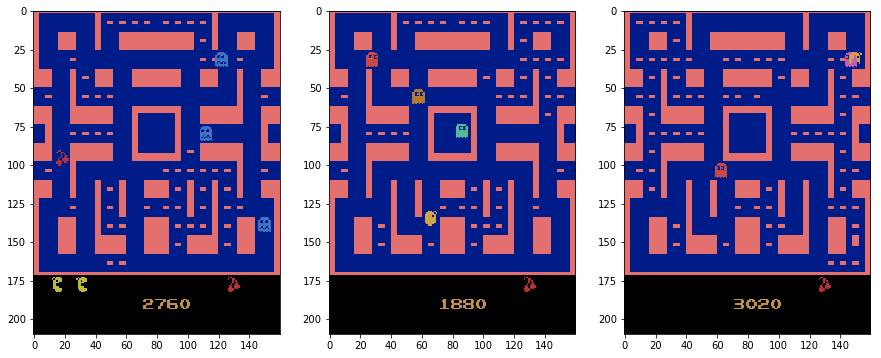

epoch 11710,loss 1005.55018, epsilon 0.05000, rewards: ( e-greedy 85.71008, greedy 106.50134) 
rec 1005.409 reg 0.142
epoch 11720,loss 601.29006, epsilon 0.05000, rewards: ( e-greedy 84.45157, greedy 106.47620) 
rec 601.149 reg 0.142
epoch 11730,loss 643.87620, epsilon 0.05000, rewards: ( e-greedy 83.63141, greedy 110.89108) 
rec 643.735 reg 0.142
epoch 11740,loss 263.60629, epsilon 0.05000, rewards: ( e-greedy 81.08077, greedy 110.48947) 
rec 263.465 reg 0.142
epoch 11750,loss 372.98886, epsilon 0.05000, rewards: ( e-greedy 79.41020, greedy 108.94053) 
rec 372.847 reg 0.142


KeyboardInterrupt: 

In [66]:
%%time

n_epochs = 30000
#25k may take hours to train.
#consider interrupt early.

for i in range(n_epochs):    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %100 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    
    #run several sessions of game, record videos and save obtained results
    if epoch_counter %1000 ==1:
        rws = np.array(pool.evaluate(n_games=20,save_path="lstm",record_video=True))
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_lstm_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

## Record videos

In [ ]:
save_path = 'lstm1/MSPacman-v0_' + str(epoch_counter-1)

subm_env = gym.make(GAME_TITLE)
# subm_env = gym.wrappers.Monitor(subm_env, 'lstm1/', forse=True)

#starting monitor. This setup does not write videos
#subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
# subm_env.monitor.start(save_path,force=True)

rws = []

for i_episode in xrange(220):

    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"

    s_reward =0.
    t = 0
    while True:

        rws = np.array(pool.evaluate(n_games=20,save_path="lstm",record_video=True))
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_lstm_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        t+=1

subm_env.close()

rws = np.array(rws)
np.savez(open('rws5hist_lstm_'+str(epoch_counter-1)+'.npz', 'wb'), rws=rws)

In [ ]:
save_path = 'lstm2/MSPacman-v0_' + str(epoch_counter-1)

subm_env = gym.make(GAME_TITLE)
# subm_env = gym.wrappers.Monitor(subm_env, 'lstm4/')

#starting monitor. This setup does not write videos
#subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
# subm_env.monitor.start(save_path,force=True)

rws = []

for i_episode in xrange(220):

    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"

    s_reward =0.
    t = 0
    while True:

        rws = np.array(pool.evaluate(n_games=20,save_path="lstm",record_video=True))
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_lstm_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        t+=1

subm_env.close()

rws = np.array(rws)
np.savez(open('rws6hist_lstm_'+str(epoch_counter-1)+'.npz', 'wb'), rws=rws)
rws

[2017-05-25 10:49:00,142] Making new env: MsPacman-v0
[2017-05-25 10:49:00,405] Making new env: MsPacman-v0
[2017-05-25 10:49:00,577] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-05-25 10:49:00,585] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.28.25470.video000000.mp4
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
[2017-05-25 10:49:02,835] Starting new video recorder wr

Episode finished after 441 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 446 timesteps with reward=60.0


[2017-05-25 10:49:15,035] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.28.25470.video000008.mp4


Episode finished after 419 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 448 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0


[2017-05-25 10:49:35,734] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:49:35,737] Making new env: MsPacman-v0


Episode finished after 428 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:49:35,937] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:49:35,946] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.29.25470.video000000.mp4
[2017-05-25 10:49:38,167] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.29.25470.video000001.mp4


Episode finished after 441 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0


[2017-05-25 10:49:50,462] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.29.25470.video000008.mp4


Episode finished after 439 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0


[2017-05-25 10:50:11,502] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:50:11,505] Making new env: MsPacman-v0


Episode finished after 434 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:50:11,704] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:50:11,713] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.30.25470.video000000.mp4
[2017-05-25 10:50:13,833] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.30.25470.video000001.mp4


Episode finished after 433 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0


[2017-05-25 10:50:27,368] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.30.25470.video000008.mp4


Episode finished after 431 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 444 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0


[2017-05-25 10:50:49,242] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:50:49,245] Making new env: MsPacman-v0


Episode finished after 432 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:50:49,444] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:50:49,453] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.31.25470.video000000.mp4
[2017-05-25 10:50:51,592] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.31.25470.video000001.mp4


Episode finished after 429 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0


[2017-05-25 10:51:05,073] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.31.25470.video000008.mp4


Episode finished after 425 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 421 timesteps with reward=60.0


[2017-05-25 10:51:26,920] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:51:26,939] Making new env: MsPacman-v0


Episode finished after 448 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:51:27,132] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:51:27,141] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.32.25470.video000000.mp4
[2017-05-25 10:51:29,426] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.32.25470.video000001.mp4


Episode finished after 439 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 420 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0


[2017-05-25 10:51:42,929] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.32.25470.video000008.mp4


Episode finished after 439 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 421 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0


[2017-05-25 10:52:06,419] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:52:06,422] Making new env: MsPacman-v0


Episode finished after 434 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:52:06,621] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:52:06,630] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.33.25470.video000000.mp4
[2017-05-25 10:52:08,833] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.33.25470.video000001.mp4


Episode finished after 425 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0


[2017-05-25 10:52:22,464] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.33.25470.video000008.mp4


Episode finished after 435 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 447 timesteps with reward=60.0
Episode finished after 421 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0


[2017-05-25 10:52:45,394] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:52:45,399] Making new env: MsPacman-v0


Episode finished after 438 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:52:45,737] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:52:45,752] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.34.25470.video000000.mp4
[2017-05-25 10:52:48,146] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.34.25470.video000001.mp4


Episode finished after 438 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0


[2017-05-25 10:53:01,723] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.34.25470.video000008.mp4


Episode finished after 443 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 444 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0


[2017-05-25 10:53:24,420] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:53:24,430] Making new env: MsPacman-v0


Episode finished after 436 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:53:24,766] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:53:24,785] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.35.25470.video000000.mp4
[2017-05-25 10:53:27,550] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.35.25470.video000001.mp4


Episode finished after 434 timesteps with reward=60.0
Episode finished after 419 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0


[2017-05-25 10:53:40,349] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.35.25470.video000008.mp4


Episode finished after 431 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 422 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0


[2017-05-25 10:54:03,290] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:54:03,292] Making new env: MsPacman-v0


Episode finished after 441 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:54:03,496] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:54:03,506] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.36.25470.video000000.mp4
[2017-05-25 10:54:05,581] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.36.25470.video000001.mp4


Episode finished after 419 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0


[2017-05-25 10:54:19,375] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.36.25470.video000008.mp4


Episode finished after 423 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 445 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0


[2017-05-25 10:54:42,794] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:54:42,799] Making new env: MsPacman-v0


Episode finished after 435 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:54:43,138] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:54:43,154] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.37.25470.video000000.mp4
[2017-05-25 10:54:46,313] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.37.25470.video000001.mp4


Episode finished after 427 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0


[2017-05-25 10:54:59,980] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.37.25470.video000008.mp4


Episode finished after 442 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0


[2017-05-25 10:55:23,257] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:55:23,260] Making new env: MsPacman-v0


Episode finished after 433 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:55:23,459] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:55:23,468] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.38.25470.video000000.mp4
[2017-05-25 10:55:25,693] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.38.25470.video000001.mp4


Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 442 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0


[2017-05-25 10:55:39,369] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.38.25470.video000008.mp4


Episode finished after 424 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 419 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0


[2017-05-25 10:56:03,073] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:56:03,075] Making new env: MsPacman-v0


Episode finished after 437 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:56:03,274] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:56:03,283] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.39.25470.video000000.mp4
[2017-05-25 10:56:05,448] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.39.25470.video000001.mp4


Episode finished after 436 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0


[2017-05-25 10:56:19,219] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.39.25470.video000008.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0


[2017-05-25 10:56:42,280] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:56:42,283] Making new env: MsPacman-v0


Episode finished after 421 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:56:42,482] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:56:42,491] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.40.25470.video000000.mp4
[2017-05-25 10:56:44,682] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.40.25470.video000001.mp4


Episode finished after 432 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0


[2017-05-25 10:56:58,278] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.40.25470.video000008.mp4


Episode finished after 435 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0


[2017-05-25 10:57:21,139] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:57:21,143] Making new env: MsPacman-v0


Episode finished after 426 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:57:21,482] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:57:21,498] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.41.25470.video000000.mp4
[2017-05-25 10:57:24,105] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.41.25470.video000001.mp4


Episode finished after 437 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0


[2017-05-25 10:57:37,630] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.41.25470.video000008.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0


[2017-05-25 10:58:01,031] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:58:01,033] Making new env: MsPacman-v0


Episode finished after 437 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:58:01,232] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:58:01,241] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.42.25470.video000000.mp4
[2017-05-25 10:58:03,671] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.42.25470.video000001.mp4


Episode finished after 425 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0


[2017-05-25 10:58:17,119] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.42.25470.video000008.mp4


Episode finished after 438 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0


[2017-05-25 10:58:40,394] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:58:40,397] Making new env: MsPacman-v0


Episode finished after 424 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:58:40,596] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:58:40,605] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.43.25470.video000000.mp4
[2017-05-25 10:58:42,760] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.43.25470.video000001.mp4


Episode finished after 438 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0


[2017-05-25 10:58:56,403] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.43.25470.video000008.mp4


Episode finished after 435 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 451 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0


[2017-05-25 10:59:19,701] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:59:19,703] Making new env: MsPacman-v0


Episode finished after 430 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:59:19,903] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:59:19,912] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.44.25470.video000000.mp4
[2017-05-25 10:59:22,144] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.44.25470.video000001.mp4


Episode finished after 446 timesteps with reward=60.0
Episode finished after 420 timesteps with reward=60.0
Episode finished after 420 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0


[2017-05-25 10:59:35,786] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.44.25470.video000008.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 445 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 442 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0


[2017-05-25 10:59:59,321] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:59:59,323] Making new env: MsPacman-v0


Episode finished after 437 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:59:59,522] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:59:59,532] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.45.25470.video000000.mp4
[2017-05-25 11:00:01,668] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.45.25470.video000001.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0


[2017-05-25 11:00:15,689] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.45.25470.video000008.mp4


Episode finished after 425 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 442 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0


[2017-05-25 11:00:38,775] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:00:38,778] Making new env: MsPacman-v0


Episode finished after 425 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:00:38,998] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:00:39,013] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.46.25470.video000000.mp4
[2017-05-25 11:00:42,175] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.46.25470.video000001.mp4


Episode finished after 432 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0


[2017-05-25 11:00:55,987] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.46.25470.video000008.mp4


Episode finished after 429 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0


[2017-05-25 11:01:19,608] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:01:19,653] Making new env: MsPacman-v0


Episode finished after 436 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:01:19,836] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:01:19,844] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.47.25470.video000000.mp4
[2017-05-25 11:01:21,971] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.47.25470.video000001.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 415 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0


[2017-05-25 11:01:35,491] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.47.25470.video000008.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0


[2017-05-25 11:01:58,661] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:01:58,666] Making new env: MsPacman-v0


Episode finished after 428 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:01:59,004] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:01:59,020] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.48.25470.video000000.mp4
[2017-05-25 11:02:01,146] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.48.25470.video000001.mp4


Episode finished after 426 timesteps with reward=60.0
Episode finished after 447 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0


[2017-05-25 11:02:14,902] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.48.25470.video000008.mp4


Episode finished after 438 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0


[2017-05-25 11:02:38,054] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:02:38,058] Making new env: MsPacman-v0


Episode finished after 437 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:02:38,397] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:02:38,413] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.49.25470.video000000.mp4
[2017-05-25 11:02:40,947] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.49.25470.video000001.mp4


Episode finished after 432 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0


[2017-05-25 11:02:54,712] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.49.25470.video000008.mp4


Episode finished after 445 timesteps with reward=60.0
Episode finished after 442 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0


[2017-05-25 11:03:18,112] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:03:18,115] Making new env: MsPacman-v0


Episode finished after 443 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:03:18,314] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:03:18,323] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.50.25470.video000000.mp4
[2017-05-25 11:03:20,485] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.50.25470.video000001.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 441 timesteps with reward=60.0


[2017-05-25 11:03:34,282] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.50.25470.video000008.mp4


Episode finished after 436 timesteps with reward=60.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0


[2017-05-25 11:03:57,639] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:03:57,642] Making new env: MsPacman-v0


Episode finished after 440 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:03:57,845] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:03:57,854] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.51.25470.video000000.mp4
[2017-05-25 11:03:59,996] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.51.25470.video000001.mp4


Episode finished after 437 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0


[2017-05-25 11:04:14,254] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.51.25470.video000008.mp4


Episode finished after 433 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0


[2017-05-25 11:04:37,607] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:04:37,610] Making new env: MsPacman-v0


Episode finished after 432 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:04:37,810] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:04:37,819] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.52.25470.video000000.mp4
[2017-05-25 11:04:40,367] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.52.25470.video000001.mp4


Episode finished after 432 timesteps with reward=60.0
Episode finished after 444 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0


[2017-05-25 11:04:54,638] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.52.25470.video000008.mp4


Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0


[2017-05-25 11:05:17,608] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:05:17,613] Making new env: MsPacman-v0


Episode finished after 430 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:05:17,952] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:05:17,968] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.53.25470.video000000.mp4
[2017-05-25 11:05:20,507] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.53.25470.video000001.mp4


Episode finished after 432 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 444 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0


[2017-05-25 11:05:34,181] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.53.25470.video000008.mp4


Episode finished after 437 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0


[2017-05-25 11:05:57,600] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 11:05:57,603] Making new env: MsPacman-v0


Episode finished after 440 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 11:05:57,802] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 11:05:57,811] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.54.25470.video000000.mp4
[2017-05-25 11:06:00,004] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.54.25470.video000001.mp4


Episode finished after 447 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 439 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0


In [80]:
np.save(open('greedy_lstm_log.pcl', 'wb'), score_log['expected greedy reward'])
np.save(open('egreedy_lstm_log.pcl', 'wb'), score_log['expected e-greedy reward'])

# Evaluating results
 * Here we plot learning curves and sample testimonials

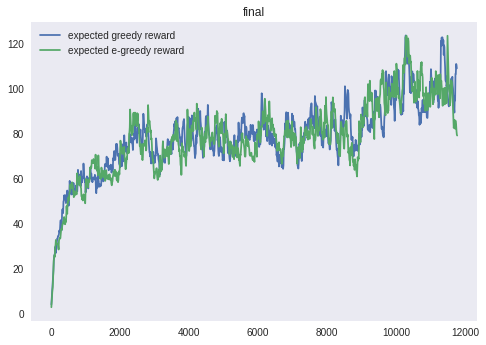

In [81]:
import seaborn as sns
score_log.plot("final")

In [82]:
np.save(open('egreedy_log.pcl', 'wb'), score_log['proba-greedy reward'])

Random session examples


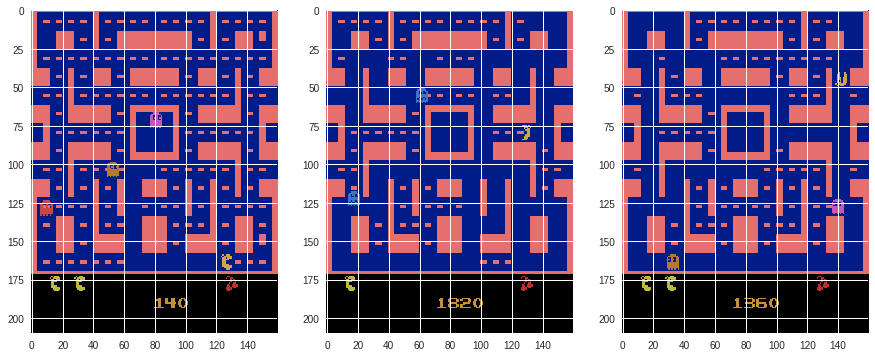

In [83]:
print("Random session examples")
display_sessions()


# Save learning curves

In [84]:
import pickle

lc = {'e-greedy':score_log['expected e-greedy reward'], 'greedy':score_log['expected greedy reward']}

with open(str(epoch_counter-1)+'iter_lc.pickle', 'wb') as handle:
    lc = pickle.dump(lc, handle)

# Submission
Here we simply run the OpenAI gym submission code and view scores

In [85]:
resolver.epsilon.set_value(0)

In [88]:
save_path = '/tmp/AgentNet-simplenet-MsPacman-v0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
# subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(200):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"
    
    
    t = 0
    while True:

        rws = np.array(pool.evaluate(n_games=20,save_path="lstm",record_video=True))
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_lstm_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        t+=1

subm_env.monitor.close()

[2017-05-25 10:13:00,279] Making new env: MsPacman-v0
[2017-05-25 10:13:00,548] Making new env: MsPacman-v0
[2017-05-25 10:13:00,720] Clearing 11 monitor files from previous run (because force=True was provided)
[2017-05-25 10:13:00,728] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.25.25470.video000000.mp4
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/weasel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
[2017-05-25 10:13:02,918] Starting new video recorder w

Episode finished after 429 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0


[2017-05-25 10:13:15,247] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.25.25470.video000008.mp4


Episode finished after 433 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 442 timesteps with reward=60.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 440 timesteps with reward=60.0


[2017-05-25 10:13:38,508] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')
[2017-05-25 10:13:38,511] Making new env: MsPacman-v0


Episode finished after 432 timesteps with reward=60.0
Mean 60.0, Var 0.0


[2017-05-25 10:13:38,710] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 10:13:38,719] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.26.25470.video000000.mp4
[2017-05-25 10:13:41,351] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.26.25470.video000001.mp4


Episode finished after 428 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 425 timesteps with reward=60.0
Episode finished after 424 timesteps with reward=60.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 436 timesteps with reward=60.0


[2017-05-25 10:13:55,790] Starting new video recorder writing to /home/weasel/lstm/openaigym.video.26.25470.video000008.mp4


Episode finished after 437 timesteps with reward=60.0


KeyboardInterrupt: 

In [89]:
[monitor.close() for monitor in gym.monitoring._open_monitors()]

[2017-05-25 10:14:02,679] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/weasel/lstm')


[None]

In [90]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)


SyntaxError: invalid syntax (<ipython-input-90-40ebb842f2ee>, line 5)

# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. agent-critic), other parameters
* Experience replay pool


Look for examples? Try examples/Deep Kung Fu for most of these features


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper

 
__Good luck!__

In [79]:
gym.upload?